In [1]:
# Learning
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import analyzer
from tokenizer import create_bag_of_words
from vectorizer import NCutVectorizer
from coherence import calculate_uci_coherence, calculate_uci_npmi_coherence, calculate_uci_npmi_coherence_all_docs

#DB
import psycopg2

# Helpers
import numpy as np
import pandas as pd
import pickle
import base64
from collections import defaultdict
import copy

### Get data and connect to DB

In [2]:
## Cleaning database
last_id = 132
# problems = Problem.objects.filter(id__gt=last_id)
# # solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
# print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be used: 132
Solutions to be used: 54
Got 54 documents


In [3]:
%%time 
# Insert to DB
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                          password = settings.DATABASES["default"]["PASSWORD"],
                          host = settings.DATABASES["default"]["HOST"],
                          port = settings.DATABASES["default"]["PORT"],
                          database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

CPU times: user 3.58 ms, sys: 0 ns, total: 3.58 ms
Wall time: 102 ms


In [4]:
def get_where_items(exp_id, cols, table):
    query = "SELECT %s from %s where experiment_id = %s" % (", ".join(cols), table, exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def get_model_properties(model_pickle, data_features):
    model_db = pickle.loads(base64.b64decode(model_pickle))
    document_topic = model_db.transform(data_features)
    document_clusters = document_topic.argmax(axis=1)
    return document_clusters, model_db.components_.T

In [5]:
exp_id = 26
cols = ["vectorizer", "min_df", "is_binary", "method", "k"]
table = "experiments_solution"
where_items = get_where_items(exp_id, cols, table)[0]
v = eval(where_items[0])
m = where_items[1]
b = where_items[2]
vectorizer_params={'ngram_range': (1,3)}
train_data_features, vectorizer, _ = create_bag_of_words(solutions, v, binary=b, min_df=m, vectorizer_params=vectorizer_params)

# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

test_data_features_lda = vectorizer.transform(new_solutions).toarray()
test_data_features_lda.shape

(65, 236)

In [6]:
select_query = "select model, " + ", ".join(cols) + """ coherence_med5, coherence_med10, coherence_med15 
FROM EXPERIMENTS_2020_02_12 where vectorizer = %s  and min_df = '%s' and is_binary = %s and
method = %s and k = %s and ngrams[1] = 1 and ngrams[2] = 3"""
query = cursor.mogrify(select_query, where_items)
query

b"select model, vectorizer, min_df, is_binary, method, k coherence_med5, coherence_med10, coherence_med15 \nFROM EXPERIMENTS_2020_02_12 where vectorizer = 'CountVectorizer'  and min_df = '0.05' and is_binary = true and\nmethod = 'lda' and k = 12 and ngrams[1] = 1 and ngrams[2] = 3"

In [11]:
cursor.execute(query)
response = cursor.fetchall()

methods = {"lda": defaultdict(list), "kmeans": defaultdict(list), "nmf": defaultdict(list)}
metrics = {
    "pmi": copy.deepcopy(methods),
    "npmi": copy.deepcopy(methods),
    "npmi_all": copy.deepcopy(methods)
}

metrics_len = {
    "pmi": copy.deepcopy(methods),
    "npmi": copy.deepcopy(methods),
    "npmi_all": copy.deepcopy(methods)
}

test_data_features = test_data_features_lda

for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            coh = calculate_uci_coherence(test_data_features, word_topic, document_clusters, 12, n)
            metrics["pmi"]["lda"][n].append(coh[1])
            metrics_len["pmi"]["lda"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate UCI Coherence Top-%d for row %d" % (n, idx))
            
print()
for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            coh = calculate_uci_npmi_coherence(test_data_features, word_topic, document_clusters, 12, n)
            metrics["npmi"]["lda"][n].append(coh[1])
            metrics_len["npmi"]["lda"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate NPMI UCI Coherence Top-%d for row %d" % (n, idx))
            
print()
for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            coh = calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, 
                                                        document_clusters, 12, n)
            metrics["npmi_all"]["lda"][n].append(coh[1])
            metrics_len["npmi_all"]["lda"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate NPMI ALL UCI Coherence Top-%d for row %d" % (n, idx))

Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-5 for row 3
Cannot calculate UCI Coherence Top-5 for row 4
Cannot calculate UCI Coherence Top-5 for row 5
Cannot calculate UCI Coherence Top-5 for row 7
Cannot calculate UCI Coherence Top-5 for row 8
Cannot calculate UCI Coherence Top-5 for row 11
Cannot calculate UCI Coherence Top-5 for row 13
Cannot calculate UCI Coherence Top-5 for row 15
Cannot calculate UCI Coherence Top-5 for row 16
Cannot calculate UCI Coherence Top-5 for row 17
Cannot calculate UCI Coherence Top-5 for row 19
Cannot calculate UCI Coherence Top-5 for row 20
Cannot calculate UCI Coherence Top-5 for row 21
Cannot calculate UCI Coherence Top-5 for row 27
Cannot calculate UCI Coherence Top-5 for row 28
Cannot calculate UCI Coherence Top-5 for row 29
Cannot calculate UCI Coherence Top-5 for row 33
Cannot calculate UCI Coherence Top-5 for row 34
Cannot calculate UCI Coherence Top-5 for row 37
Cannot calculate UCI Coherence Top-5 for row 3

Cannot calculate UCI Coherence Top-15 for row 68
Cannot calculate UCI Coherence Top-15 for row 69
Cannot calculate UCI Coherence Top-15 for row 70
Cannot calculate UCI Coherence Top-15 for row 71
Cannot calculate UCI Coherence Top-15 for row 72
Cannot calculate UCI Coherence Top-15 for row 73
Cannot calculate UCI Coherence Top-15 for row 74
Cannot calculate UCI Coherence Top-15 for row 75
Cannot calculate UCI Coherence Top-15 for row 76
Cannot calculate UCI Coherence Top-15 for row 77
Cannot calculate UCI Coherence Top-15 for row 78
Cannot calculate UCI Coherence Top-15 for row 80
Cannot calculate UCI Coherence Top-15 for row 81
Cannot calculate UCI Coherence Top-15 for row 82
Cannot calculate UCI Coherence Top-15 for row 83
Cannot calculate UCI Coherence Top-15 for row 84
Cannot calculate UCI Coherence Top-15 for row 85
Cannot calculate UCI Coherence Top-15 for row 86
Cannot calculate UCI Coherence Top-15 for row 87
Cannot calculate UCI Coherence Top-15 for row 88
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-15 for row 17
Cannot calculate NPMI UCI Coherence Top-15 for row 18
Cannot calculate NPMI UCI Coherence Top-15 for row 19
Cannot calculate NPMI UCI Coherence Top-15 for row 20
Cannot calculate NPMI UCI Coherence Top-15 for row 21
Cannot calculate NPMI UCI Coherence Top-15 for row 23
Cannot calculate NPMI UCI Coherence Top-15 for row 24
Cannot calculate NPMI UCI Coherence Top-15 for row 25
Cannot calculate NPMI UCI Coherence Top-15 for row 26
Cannot calculate NPMI UCI Coherence Top-15 for row 27
Cannot calculate NPMI UCI Coherence Top-15 for row 28
Cannot calculate NPMI UCI Coherence Top-15 for row 29
Cannot calculate NPMI UCI Coherence Top-15 for row 30
Cannot calculate NPMI UCI Coherence Top-15 for row 33
Cannot calculate NPMI UCI Coherence Top-15 for row 34
Cannot calculate NPMI UCI Coherence Top-15 for row 37
Cannot calculate NPMI UCI Coherence Top-15 for row 38
Cannot calculate NPMI UCI Coherence Top-15 for row 39
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 52
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 53
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 56
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 57
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 61
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 62
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 64
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 66
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 68
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 69
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 70
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 71
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 73
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 75
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 77
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 78
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 81
Cannot calcula

In [15]:
kmeans_pmi = defaultdict(list)
kmeans_npmi = defaultdict(list)
kmeans_npmi_all = defaultdict(list)

for idx in range(100):
    model = KMeans(n_clusters=5)
    clusters_train = model.fit_predict(train_data_features)
    clf = LogisticRegression(multi_class='ovr').fit(train_data_features, clusters_train)
    word_topic = clf.coef_.T

    # Get test solutions clusters
    document_clusters = model.predict(test_data_features)

    for n in [5,10,15]:
        try:
            coh = calculate_uci_coherence(test_data_features, word_topic, document_clusters, 5, n)
            metrics["pmi"]["kmeans"][n].append(coh[1])
            metrics_len["pmi"]["kmeans"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate UCI Coherence Top-%d for row %d" % (n, idx))

    print()
    for n in [5,10,15]:
        try:
            coh = calculate_uci_npmi_coherence(test_data_features, word_topic, document_clusters, 5, n)
            metrics["npmi"]["kmeans"][n].append(coh[1])
            metrics_len["npmi"]["kmeans"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate NPMI UCI Coherence Top-%d for row %d" % (n, idx))
            
    print()
    for n in [5,10,15]:
        try:
            coh = calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, 
                                                        document_clusters, 5, n)
            metrics["npmi_all"]["kmeans"][n].append(coh[1])
            metrics_len["npmi_all"]["kmeans"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate NPMI ALL UCI Coherence Top-%d for row %d" % (n, idx))

Cannot calculate UCI Coherence Top-10 for row 0
Cannot calculate UCI Coherence Top-15 for row 0

Cannot calculate NPMI UCI Coherence Top-10 for row 0
Cannot calculate NPMI UCI Coherence Top-15 for row 0

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 0
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 0
Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-10 for row 1
Cannot calculate UCI Coherence Top-15 for row 1

Cannot calculate NPMI UCI Coherence Top-5 for row 1
Cannot calculate NPMI UCI Coherence Top-10 for row 1
Cannot calculate NPMI UCI Coherence Top-15 for row 1

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 1
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 1
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 1
Cannot calculate UCI Coherence Top-10 for row 2
Cannot calculate UCI Coherence Top-15 for row 2

Cannot calculate NPMI UCI Coherence Top-10 for row 2
Cannot calculate NPMI UCI Coherence Top-15 for row 2

Canno

Cannot calculate UCI Coherence Top-5 for row 22
Cannot calculate UCI Coherence Top-10 for row 22
Cannot calculate UCI Coherence Top-15 for row 22

Cannot calculate NPMI UCI Coherence Top-5 for row 22
Cannot calculate NPMI UCI Coherence Top-10 for row 22
Cannot calculate NPMI UCI Coherence Top-15 for row 22

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 22
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 22
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 22
Cannot calculate UCI Coherence Top-5 for row 23
Cannot calculate UCI Coherence Top-10 for row 23
Cannot calculate UCI Coherence Top-15 for row 23

Cannot calculate NPMI UCI Coherence Top-5 for row 23
Cannot calculate NPMI UCI Coherence Top-10 for row 23
Cannot calculate NPMI UCI Coherence Top-15 for row 23

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 23
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 23
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 23
Cannot calculate UCI Coherence Top-1

Cannot calculate NPMI UCI Coherence Top-10 for row 43
Cannot calculate NPMI UCI Coherence Top-15 for row 43

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 43
Cannot calculate UCI Coherence Top-10 for row 44
Cannot calculate UCI Coherence Top-15 for row 44

Cannot calculate NPMI UCI Coherence Top-10 for row 44
Cannot calculate NPMI UCI Coherence Top-15 for row 44

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 44
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 44
Cannot calculate UCI Coherence Top-10 for row 45
Cannot calculate UCI Coherence Top-15 for row 45

Cannot calculate NPMI UCI Coherence Top-10 for row 45
Cannot calculate NPMI UCI Coherence Top-15 for row 45

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 45
Cannot calculate UCI Coherence Top-5 for row 46
Cannot calculate UCI Coherence Top-10 for row 46
Cannot calculate UCI Coherence

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 63
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 63
Cannot calculate UCI Coherence Top-5 for row 64
Cannot calculate UCI Coherence Top-10 for row 64
Cannot calculate UCI Coherence Top-15 for row 64

Cannot calculate NPMI UCI Coherence Top-5 for row 64
Cannot calculate NPMI UCI Coherence Top-10 for row 64
Cannot calculate NPMI UCI Coherence Top-15 for row 64

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 64
Cannot calculate UCI Coherence Top-10 for row 65
Cannot calculate UCI Coherence Top-15 for row 65

Cannot calculate NPMI UCI Coherence Top-10 for row 65
Cannot calculate NPMI UCI Coherence Top-15 for row 65

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 65
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 65
Cannot calculate UCI Coherence Top-15 for row 66

Cannot calculate NPMI UCI Coherence Top-15 for row 66

Cannot calculate UCI Coherence Top-5 for row 67
Cannot calculate UCI Coherence Top-10 fo

Cannot calculate UCI Coherence Top-5 for row 87
Cannot calculate UCI Coherence Top-10 for row 87
Cannot calculate UCI Coherence Top-15 for row 87

Cannot calculate NPMI UCI Coherence Top-5 for row 87
Cannot calculate NPMI UCI Coherence Top-10 for row 87
Cannot calculate NPMI UCI Coherence Top-15 for row 87

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 87
Cannot calculate UCI Coherence Top-5 for row 88
Cannot calculate UCI Coherence Top-10 for row 88
Cannot calculate UCI Coherence Top-15 for row 88

Cannot calculate NPMI UCI Coherence Top-5 for row 88
Cannot calculate NPMI UCI Coherence Top-10 for row 88
Cannot calculate NPMI UCI Coherence Top-15 for row 88

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 88
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 88
Cannot calculate UCI Coherence Top-5 for row 89
Cannot calculate UCI Coherence Top-10 for row 89
Cannot calculate UCI Coherence Top-15 for row 89

Cannot calculate NPMI UCI Coherence Top-5 for row 89
Cannot c

In [16]:
metrics_len

{'pmi': {'lda': defaultdict(list,
              {5: [6,
                7,
                6,
                7,
                7,
                6,
                7,
                7,
                5,
                5,
                5,
                7,
                8,
                6,
                4,
                7,
                7,
                6,
                7,
                6,
                8,
                5,
                4,
                4,
                6,
                4,
                5,
                7,
                6,
                7,
                5,
                7,
                8,
                7,
                5,
                8,
                6,
                6,
                7,
                8,
                6,
                6,
                6,
                7,
                5,
                6,
                5,
                7,
                5,
                6,
             

In [49]:
exp_id = 1463
cols = ["vectorizer", "min_df", "is_binary", "method", "k"]
table = "experiments_solution"
where_items = get_where_items(exp_id, cols, table)[0]
v = eval(where_items[0])
m = where_items[1]
b = where_items[2]
vectorizer_params={'ngram_range': (1,3)}
train_data_features, vectorizer, _ = create_bag_of_words(solutions, v, binary=b, min_df=m, vectorizer_params=vectorizer_params)

# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

test_data_features_nmf = vectorizer.transform(new_solutions)
test_data_features_nmf.shape

(65, 23)

In [50]:
select_query = "select model, " + ", ".join(cols) + """ coherence_med5, coherence_med10, coherence_med15 
FROM EXPERIMENTS_2020_02_12 where vectorizer = %s  and min_df = '%s' and is_binary = %s and
method = %s and k = %s and ngrams[1] = 1 and ngrams[2] = 3"""
query = cursor.mogrify(select_query, where_items)
query

b"select model, vectorizer, min_df, is_binary, method, k coherence_med5, coherence_med10, coherence_med15 \nFROM EXPERIMENTS_2020_02_12 where vectorizer = 'NCutVectorizer'  and min_df = '0.35' and is_binary = true and\nmethod = 'nmf' and k = 7 and ngrams[1] = 1 and ngrams[2] = 3"

In [51]:
cursor.execute(query)
response = cursor.fetchall()
test_data_features = test_data_features_nmf

for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            coh = calculate_uci_coherence(test_data_features, word_topic, document_clusters, 7, n)
            metrics["pmi"]["nmf"][n].append(coh[1])
            metrics_len["pmi"]["nmf"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate UCI Coherence Top-%d for row %d" % (n, idx))
            
print()
for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            coh = calculate_uci_npmi_coherence(test_data_features, word_topic, document_clusters, 7, n)
            metrics["npmi"]["nmf"][n].append(coh[1])
            metrics_len["npmi"]["nmf"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate NPMI UCI Coherence Top-%d for row %d" % (n, idx))
            
print()
for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            coh = calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, 
                                                        document_clusters, 7, n)
            metrics["npmi_all"]["nmf"][n].append(coh[1])
            metrics_len["npmi_all"]["nmf"][n].append(len(coh[0]))
        except RuntimeError:
            print("Cannot calculate NPMI ALL UCI Coherence Top-%d for row %d" % (n, idx))

Cannot calculate UCI Coherence Top-5 for row 0
Cannot calculate UCI Coherence Top-5 for row 7
Cannot calculate UCI Coherence Top-5 for row 13
Cannot calculate UCI Coherence Top-5 for row 20
Cannot calculate UCI Coherence Top-5 for row 22
Cannot calculate UCI Coherence Top-5 for row 23
Cannot calculate UCI Coherence Top-5 for row 24
Cannot calculate UCI Coherence Top-5 for row 31
Cannot calculate UCI Coherence Top-5 for row 33
Cannot calculate UCI Coherence Top-5 for row 45
Cannot calculate UCI Coherence Top-5 for row 47
Cannot calculate UCI Coherence Top-5 for row 49
Cannot calculate UCI Coherence Top-5 for row 51
Cannot calculate UCI Coherence Top-5 for row 54
Cannot calculate UCI Coherence Top-5 for row 56
Cannot calculate UCI Coherence Top-5 for row 60
Cannot calculate UCI Coherence Top-5 for row 62
Cannot calculate UCI Coherence Top-5 for row 66
Cannot calculate UCI Coherence Top-5 for row 74
Cannot calculate UCI Coherence Top-5 for row 75
Cannot calculate UCI Coherence Top-5 for r

Cannot calculate NPMI UCI Coherence Top-5 for row 13
Cannot calculate NPMI UCI Coherence Top-5 for row 20
Cannot calculate NPMI UCI Coherence Top-5 for row 22
Cannot calculate NPMI UCI Coherence Top-5 for row 23
Cannot calculate NPMI UCI Coherence Top-5 for row 24
Cannot calculate NPMI UCI Coherence Top-5 for row 31
Cannot calculate NPMI UCI Coherence Top-5 for row 33
Cannot calculate NPMI UCI Coherence Top-5 for row 45
Cannot calculate NPMI UCI Coherence Top-5 for row 47
Cannot calculate NPMI UCI Coherence Top-5 for row 49
Cannot calculate NPMI UCI Coherence Top-5 for row 51
Cannot calculate NPMI UCI Coherence Top-5 for row 54
Cannot calculate NPMI UCI Coherence Top-5 for row 56
Cannot calculate NPMI UCI Coherence Top-5 for row 60
Cannot calculate NPMI UCI Coherence Top-5 for row 62
Cannot calculate NPMI UCI Coherence Top-5 for row 66
Cannot calculate NPMI UCI Coherence Top-5 for row 74
Cannot calculate NPMI UCI Coherence Top-5 for row 75
Cannot calculate NPMI UCI Coherence Top-5 for 

In [45]:
def create_regular_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2, vectorizer_params=None):
    vectorizer = vectorizer_method(analyzer = 'word',
                                   binary=binary,
                                   min_df=min_df,
                                   **vectorizer_params)
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features, vectorizer, vectorizer.get_feature_names()

In [58]:
regular_query = """select vectorizer, min_df, is_binary, ngrams, method, k FROM EXPERIMENTS_REGULAR_2020_02_18 
group by  vectorizer, min_df, is_binary, ngrams, method, k
having avg(coherence_med5) <> 'NaN'
order by avg(coherence_med5) desc """

cursor.execute(regular_query)
where_items = cursor.fetchall()


for i, item in enumerate(where_items):
    print(item)
    v = eval(item[0])
    m = item[1]
    b = item[2]
    vectorizer_params={'ngram_range': item[3]}
    k = item[5]
    train_data_features, vectorizer, _ = create_regular_bag_of_words(solutions, v, binary=b, min_df=m, vectorizer_params=vectorizer_params)
    
    # Get new solutions
    problems = Problem.objects.exclude(chapter=None)
    new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

    test_data_features_regular = vectorizer.transform(new_solutions)
    
    select_query = "select model, " + ", ".join(cols) + """, coherence_med5, coherence_med10, coherence_med15 
    FROM EXPERIMENTS_REGULAR_2020_02_18 where vectorizer = %s  and min_df = '%s' and is_binary = %s and
    method = %s and k = %s and ngrams[1] = %s and ngrams[2] = %s"""
    query = cursor.mogrify(select_query, (item[0], m, b, item[4], k, item[3][0], item[3][1]))
    cursor.execute(query)
    response = cursor.fetchall()
    
    test_data_features = test_data_features_regular.todense()
    
    metrics["pmi"]["regular_%d" % i] = defaultdict(list)
    metrics["npmi"]["regular_%d" % i] = defaultdict(list)
    metrics["npmi_all"]["regular_%d" % i] = defaultdict(list)
    metrics_len["pmi"]["regular_%d" % i] = defaultdict(list)
    metrics_len["npmi"]["regular_%d" % i] = defaultdict(list)
    metrics_len["npmi_all"]["regular_%d" % i] = defaultdict(list)
    
    for n in [5,10,15]:
        for idx, row in enumerate(response):
            document_clusters, word_topic = get_model_properties(row[0], test_data_features)
            try:
                coh = calculate_uci_coherence(test_data_features, word_topic, document_clusters, k, n)
                metrics["pmi"]["regular_%d" % i][n].append(coh[1])
                metrics_len["pmi"]["regular_%d" % i][n].append(len(coh[0]))
            except RuntimeError:
                print("Cannot calculate UCI Coherence Top-%d for row %d" % (n, idx))

    print()
    for n in [5,10,15]:
        for idx, row in enumerate(response):
            document_clusters, word_topic = get_model_properties(row[0], test_data_features)
            try:
                coh = calculate_uci_npmi_coherence(test_data_features, word_topic, document_clusters, k, n)
                metrics["npmi"]["regular_%d" % i][n].append(coh[1])
                metrics_len["npmi"]["regular_%d" % i][n].append(len(coh[0]))
            except RuntimeError:
                print("Cannot calculate NPMI UCI Coherence Top-%d for row %d" % (n, idx))

    print()
    for n in [5,10,15]:
        for idx, row in enumerate(response):
            document_clusters, word_topic = get_model_properties(row[0], test_data_features)
            try:
                coh = calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, 
                                                            document_clusters, k, n)
                metrics["npmi_all"]["regular_%d" % i][n].append(coh[1])
                metrics_len["npmi_all"]["regular_%d" % i][n].append(len(coh[0]))
            except RuntimeError:
                print("Cannot calculate NPMI ALL UCI Coherence Top-%d for row %d" % (n, idx))

('CountVectorizer', 0.1, True, [1, 3], 'lda', 15)
Cannot calculate UCI Coherence Top-5 for row 0
Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-5 for row 2
Cannot calculate UCI Coherence Top-5 for row 3
Cannot calculate UCI Coherence Top-5 for row 4
Cannot calculate UCI Coherence Top-5 for row 5
Cannot calculate UCI Coherence Top-5 for row 6
Cannot calculate UCI Coherence Top-5 for row 7
Cannot calculate UCI Coherence Top-5 for row 8
Cannot calculate UCI Coherence Top-5 for row 9
Cannot calculate UCI Coherence Top-5 for row 11
Cannot calculate UCI Coherence Top-5 for row 12
Cannot calculate UCI Coherence Top-5 for row 13
Cannot calculate UCI Coherence Top-5 for row 14
Cannot calculate UCI Coherence Top-5 for row 15
Cannot calculate UCI Coherence Top-5 for row 16
Cannot calculate UCI Coherence Top-5 for row 17
Cannot calculate UCI Coherence Top-5 for row 18
Cannot calculate UCI Coherence Top-5 for row 19
Cannot calculate UCI Coherence Top-5 for row 21


Cannot calculate UCI Coherence Top-10 for row 80
Cannot calculate UCI Coherence Top-10 for row 81
Cannot calculate UCI Coherence Top-10 for row 82
Cannot calculate UCI Coherence Top-10 for row 83
Cannot calculate UCI Coherence Top-10 for row 84
Cannot calculate UCI Coherence Top-10 for row 85
Cannot calculate UCI Coherence Top-10 for row 86
Cannot calculate UCI Coherence Top-10 for row 87
Cannot calculate UCI Coherence Top-10 for row 88
Cannot calculate UCI Coherence Top-10 for row 89
Cannot calculate UCI Coherence Top-10 for row 90
Cannot calculate UCI Coherence Top-10 for row 91
Cannot calculate UCI Coherence Top-10 for row 92
Cannot calculate UCI Coherence Top-10 for row 93
Cannot calculate UCI Coherence Top-10 for row 94
Cannot calculate UCI Coherence Top-10 for row 95
Cannot calculate UCI Coherence Top-10 for row 96
Cannot calculate UCI Coherence Top-10 for row 97
Cannot calculate UCI Coherence Top-10 for row 98
Cannot calculate UCI Coherence Top-10 for row 99
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 50
Cannot calculate NPMI UCI Coherence Top-5 for row 51
Cannot calculate NPMI UCI Coherence Top-5 for row 52
Cannot calculate NPMI UCI Coherence Top-5 for row 53
Cannot calculate NPMI UCI Coherence Top-5 for row 54
Cannot calculate NPMI UCI Coherence Top-5 for row 55
Cannot calculate NPMI UCI Coherence Top-5 for row 57
Cannot calculate NPMI UCI Coherence Top-5 for row 58
Cannot calculate NPMI UCI Coherence Top-5 for row 59
Cannot calculate NPMI UCI Coherence Top-5 for row 60
Cannot calculate NPMI UCI Coherence Top-5 for row 61
Cannot calculate NPMI UCI Coherence Top-5 for row 62
Cannot calculate NPMI UCI Coherence Top-5 for row 64
Cannot calculate NPMI UCI Coherence Top-5 for row 65
Cannot calculate NPMI UCI Coherence Top-5 for row 66
Cannot calculate NPMI UCI Coherence Top-5 for row 67
Cannot calculate NPMI UCI Coherence Top-5 for row 68
Cannot calculate NPMI UCI Coherence Top-5 for row 69
Cannot calculate NPMI UCI Coherence Top-5 for 

Cannot calculate NPMI UCI Coherence Top-15 for row 18
Cannot calculate NPMI UCI Coherence Top-15 for row 19
Cannot calculate NPMI UCI Coherence Top-15 for row 20
Cannot calculate NPMI UCI Coherence Top-15 for row 21
Cannot calculate NPMI UCI Coherence Top-15 for row 22
Cannot calculate NPMI UCI Coherence Top-15 for row 23
Cannot calculate NPMI UCI Coherence Top-15 for row 24
Cannot calculate NPMI UCI Coherence Top-15 for row 25
Cannot calculate NPMI UCI Coherence Top-15 for row 26
Cannot calculate NPMI UCI Coherence Top-15 for row 27
Cannot calculate NPMI UCI Coherence Top-15 for row 28
Cannot calculate NPMI UCI Coherence Top-15 for row 29
Cannot calculate NPMI UCI Coherence Top-15 for row 30
Cannot calculate NPMI UCI Coherence Top-15 for row 31
Cannot calculate NPMI UCI Coherence Top-15 for row 32
Cannot calculate NPMI UCI Coherence Top-15 for row 33
Cannot calculate NPMI UCI Coherence Top-15 for row 34
Cannot calculate NPMI UCI Coherence Top-15 for row 35
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 42
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 44
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 46
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 47
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 48
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 49
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 50
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 52
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 53
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 54
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 55
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 56
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 57
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 58
Cannot calcula

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 86
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 87
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 88
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 89
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 90
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 91
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 92
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 93
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 94
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 95
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 96
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 97
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 98
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 99
('CountVectorizer', 0.1, True, [1, 2], 'lda', 15)
Cannot calculate UCI Coherence Top-5 for row 0
Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-5 for row

Cannot calculate UCI Coherence Top-10 for row 79
Cannot calculate UCI Coherence Top-10 for row 80
Cannot calculate UCI Coherence Top-10 for row 81
Cannot calculate UCI Coherence Top-10 for row 82
Cannot calculate UCI Coherence Top-10 for row 83
Cannot calculate UCI Coherence Top-10 for row 84
Cannot calculate UCI Coherence Top-10 for row 85
Cannot calculate UCI Coherence Top-10 for row 86
Cannot calculate UCI Coherence Top-10 for row 87
Cannot calculate UCI Coherence Top-10 for row 88
Cannot calculate UCI Coherence Top-10 for row 89
Cannot calculate UCI Coherence Top-10 for row 90
Cannot calculate UCI Coherence Top-10 for row 91
Cannot calculate UCI Coherence Top-10 for row 92
Cannot calculate UCI Coherence Top-10 for row 93
Cannot calculate UCI Coherence Top-10 for row 94
Cannot calculate UCI Coherence Top-10 for row 95
Cannot calculate UCI Coherence Top-10 for row 96
Cannot calculate UCI Coherence Top-10 for row 97
Cannot calculate UCI Coherence Top-10 for row 98
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 62
Cannot calculate NPMI UCI Coherence Top-5 for row 64
Cannot calculate NPMI UCI Coherence Top-5 for row 66
Cannot calculate NPMI UCI Coherence Top-5 for row 68
Cannot calculate NPMI UCI Coherence Top-5 for row 69
Cannot calculate NPMI UCI Coherence Top-5 for row 70
Cannot calculate NPMI UCI Coherence Top-5 for row 71
Cannot calculate NPMI UCI Coherence Top-5 for row 72
Cannot calculate NPMI UCI Coherence Top-5 for row 75
Cannot calculate NPMI UCI Coherence Top-5 for row 76
Cannot calculate NPMI UCI Coherence Top-5 for row 77
Cannot calculate NPMI UCI Coherence Top-5 for row 78
Cannot calculate NPMI UCI Coherence Top-5 for row 79
Cannot calculate NPMI UCI Coherence Top-5 for row 80
Cannot calculate NPMI UCI Coherence Top-5 for row 82
Cannot calculate NPMI UCI Coherence Top-5 for row 83
Cannot calculate NPMI UCI Coherence Top-5 for row 84
Cannot calculate NPMI UCI Coherence Top-5 for row 85
Cannot calculate NPMI UCI Coherence Top-5 for 

Cannot calculate NPMI UCI Coherence Top-15 for row 30
Cannot calculate NPMI UCI Coherence Top-15 for row 31
Cannot calculate NPMI UCI Coherence Top-15 for row 32
Cannot calculate NPMI UCI Coherence Top-15 for row 33
Cannot calculate NPMI UCI Coherence Top-15 for row 34
Cannot calculate NPMI UCI Coherence Top-15 for row 35
Cannot calculate NPMI UCI Coherence Top-15 for row 36
Cannot calculate NPMI UCI Coherence Top-15 for row 37
Cannot calculate NPMI UCI Coherence Top-15 for row 38
Cannot calculate NPMI UCI Coherence Top-15 for row 39
Cannot calculate NPMI UCI Coherence Top-15 for row 40
Cannot calculate NPMI UCI Coherence Top-15 for row 41
Cannot calculate NPMI UCI Coherence Top-15 for row 42
Cannot calculate NPMI UCI Coherence Top-15 for row 43
Cannot calculate NPMI UCI Coherence Top-15 for row 44
Cannot calculate NPMI UCI Coherence Top-15 for row 45
Cannot calculate NPMI UCI Coherence Top-15 for row 46
Cannot calculate NPMI UCI Coherence Top-15 for row 47
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 50
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 52
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 53
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 54
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 55
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 56
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 57
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 58
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 59
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 60
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 61
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 62
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 63
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 64
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 65
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 66
Cannot calcula

Cannot calculate UCI Coherence Top-5 for row 0
Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-5 for row 2
Cannot calculate UCI Coherence Top-5 for row 3
Cannot calculate UCI Coherence Top-5 for row 4
Cannot calculate UCI Coherence Top-5 for row 5
Cannot calculate UCI Coherence Top-5 for row 6
Cannot calculate UCI Coherence Top-5 for row 7
Cannot calculate UCI Coherence Top-5 for row 9
Cannot calculate UCI Coherence Top-5 for row 10
Cannot calculate UCI Coherence Top-5 for row 11
Cannot calculate UCI Coherence Top-5 for row 12
Cannot calculate UCI Coherence Top-5 for row 13
Cannot calculate UCI Coherence Top-5 for row 14
Cannot calculate UCI Coherence Top-5 for row 16
Cannot calculate UCI Coherence Top-5 for row 17
Cannot calculate UCI Coherence Top-5 for row 18
Cannot calculate UCI Coherence Top-5 for row 19
Cannot calculate UCI Coherence Top-5 for row 20
Cannot calculate UCI Coherence Top-5 for row 21
Cannot calculate UCI Coherence Top-5 for row 22
C

Cannot calculate UCI Coherence Top-10 for row 94
Cannot calculate UCI Coherence Top-10 for row 95
Cannot calculate UCI Coherence Top-10 for row 96
Cannot calculate UCI Coherence Top-10 for row 97
Cannot calculate UCI Coherence Top-10 for row 98
Cannot calculate UCI Coherence Top-10 for row 99
Cannot calculate UCI Coherence Top-15 for row 0
Cannot calculate UCI Coherence Top-15 for row 1
Cannot calculate UCI Coherence Top-15 for row 2
Cannot calculate UCI Coherence Top-15 for row 3
Cannot calculate UCI Coherence Top-15 for row 4
Cannot calculate UCI Coherence Top-15 for row 5
Cannot calculate UCI Coherence Top-15 for row 6
Cannot calculate UCI Coherence Top-15 for row 7
Cannot calculate UCI Coherence Top-15 for row 8
Cannot calculate UCI Coherence Top-15 for row 9
Cannot calculate UCI Coherence Top-15 for row 10
Cannot calculate UCI Coherence Top-15 for row 11
Cannot calculate UCI Coherence Top-15 for row 12
Cannot calculate UCI Coherence Top-15 for row 13
Cannot calculate UCI Coherence

Cannot calculate NPMI UCI Coherence Top-5 for row 69
Cannot calculate NPMI UCI Coherence Top-5 for row 70
Cannot calculate NPMI UCI Coherence Top-5 for row 71
Cannot calculate NPMI UCI Coherence Top-5 for row 72
Cannot calculate NPMI UCI Coherence Top-5 for row 73
Cannot calculate NPMI UCI Coherence Top-5 for row 74
Cannot calculate NPMI UCI Coherence Top-5 for row 76
Cannot calculate NPMI UCI Coherence Top-5 for row 77
Cannot calculate NPMI UCI Coherence Top-5 for row 78
Cannot calculate NPMI UCI Coherence Top-5 for row 79
Cannot calculate NPMI UCI Coherence Top-5 for row 80
Cannot calculate NPMI UCI Coherence Top-5 for row 82
Cannot calculate NPMI UCI Coherence Top-5 for row 83
Cannot calculate NPMI UCI Coherence Top-5 for row 84
Cannot calculate NPMI UCI Coherence Top-5 for row 85
Cannot calculate NPMI UCI Coherence Top-5 for row 86
Cannot calculate NPMI UCI Coherence Top-5 for row 87
Cannot calculate NPMI UCI Coherence Top-5 for row 88
Cannot calculate NPMI UCI Coherence Top-5 for 

Cannot calculate NPMI UCI Coherence Top-15 for row 38
Cannot calculate NPMI UCI Coherence Top-15 for row 39
Cannot calculate NPMI UCI Coherence Top-15 for row 40
Cannot calculate NPMI UCI Coherence Top-15 for row 41
Cannot calculate NPMI UCI Coherence Top-15 for row 42
Cannot calculate NPMI UCI Coherence Top-15 for row 43
Cannot calculate NPMI UCI Coherence Top-15 for row 44
Cannot calculate NPMI UCI Coherence Top-15 for row 45
Cannot calculate NPMI UCI Coherence Top-15 for row 46
Cannot calculate NPMI UCI Coherence Top-15 for row 47
Cannot calculate NPMI UCI Coherence Top-15 for row 48
Cannot calculate NPMI UCI Coherence Top-15 for row 49
Cannot calculate NPMI UCI Coherence Top-15 for row 50
Cannot calculate NPMI UCI Coherence Top-15 for row 51
Cannot calculate NPMI UCI Coherence Top-15 for row 52
Cannot calculate NPMI UCI Coherence Top-15 for row 53
Cannot calculate NPMI UCI Coherence Top-15 for row 54
Cannot calculate NPMI UCI Coherence Top-15 for row 55
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 66
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 67
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 68
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 69
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 70
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 71
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 72
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 73
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 74
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 75
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 76
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 77
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 78
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 79
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 80
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 81
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 82
Cannot calcula

Cannot calculate UCI Coherence Top-5 for row 16
Cannot calculate UCI Coherence Top-5 for row 17
Cannot calculate UCI Coherence Top-5 for row 18
Cannot calculate UCI Coherence Top-5 for row 19
Cannot calculate UCI Coherence Top-5 for row 20
Cannot calculate UCI Coherence Top-5 for row 21
Cannot calculate UCI Coherence Top-5 for row 24
Cannot calculate UCI Coherence Top-5 for row 26
Cannot calculate UCI Coherence Top-5 for row 27
Cannot calculate UCI Coherence Top-5 for row 29
Cannot calculate UCI Coherence Top-5 for row 30
Cannot calculate UCI Coherence Top-5 for row 31
Cannot calculate UCI Coherence Top-5 for row 32
Cannot calculate UCI Coherence Top-5 for row 33
Cannot calculate UCI Coherence Top-5 for row 34
Cannot calculate UCI Coherence Top-5 for row 35
Cannot calculate UCI Coherence Top-5 for row 37
Cannot calculate UCI Coherence Top-5 for row 38
Cannot calculate UCI Coherence Top-5 for row 39
Cannot calculate UCI Coherence Top-5 for row 40
Cannot calculate UCI Coherence Top-5 for

Cannot calculate UCI Coherence Top-15 for row 1
Cannot calculate UCI Coherence Top-15 for row 2
Cannot calculate UCI Coherence Top-15 for row 3
Cannot calculate UCI Coherence Top-15 for row 4
Cannot calculate UCI Coherence Top-15 for row 5
Cannot calculate UCI Coherence Top-15 for row 6
Cannot calculate UCI Coherence Top-15 for row 7
Cannot calculate UCI Coherence Top-15 for row 8
Cannot calculate UCI Coherence Top-15 for row 9
Cannot calculate UCI Coherence Top-15 for row 10
Cannot calculate UCI Coherence Top-15 for row 11
Cannot calculate UCI Coherence Top-15 for row 12
Cannot calculate UCI Coherence Top-15 for row 13
Cannot calculate UCI Coherence Top-15 for row 14
Cannot calculate UCI Coherence Top-15 for row 15
Cannot calculate UCI Coherence Top-15 for row 16
Cannot calculate UCI Coherence Top-15 for row 17
Cannot calculate UCI Coherence Top-15 for row 18
Cannot calculate UCI Coherence Top-15 for row 19
Cannot calculate UCI Coherence Top-15 for row 20
Cannot calculate UCI Coherenc

Cannot calculate NPMI UCI Coherence Top-5 for row 85
Cannot calculate NPMI UCI Coherence Top-5 for row 87
Cannot calculate NPMI UCI Coherence Top-5 for row 88
Cannot calculate NPMI UCI Coherence Top-5 for row 90
Cannot calculate NPMI UCI Coherence Top-5 for row 91
Cannot calculate NPMI UCI Coherence Top-5 for row 92
Cannot calculate NPMI UCI Coherence Top-5 for row 93
Cannot calculate NPMI UCI Coherence Top-5 for row 94
Cannot calculate NPMI UCI Coherence Top-5 for row 95
Cannot calculate NPMI UCI Coherence Top-5 for row 96
Cannot calculate NPMI UCI Coherence Top-5 for row 97
Cannot calculate NPMI UCI Coherence Top-5 for row 99
Cannot calculate NPMI UCI Coherence Top-10 for row 0
Cannot calculate NPMI UCI Coherence Top-10 for row 1
Cannot calculate NPMI UCI Coherence Top-10 for row 2
Cannot calculate NPMI UCI Coherence Top-10 for row 3
Cannot calculate NPMI UCI Coherence Top-10 for row 4
Cannot calculate NPMI UCI Coherence Top-10 for row 5
Cannot calculate NPMI UCI Coherence Top-10 for

Cannot calculate NPMI UCI Coherence Top-15 for row 41
Cannot calculate NPMI UCI Coherence Top-15 for row 42
Cannot calculate NPMI UCI Coherence Top-15 for row 43
Cannot calculate NPMI UCI Coherence Top-15 for row 44
Cannot calculate NPMI UCI Coherence Top-15 for row 45
Cannot calculate NPMI UCI Coherence Top-15 for row 46
Cannot calculate NPMI UCI Coherence Top-15 for row 47
Cannot calculate NPMI UCI Coherence Top-15 for row 48
Cannot calculate NPMI UCI Coherence Top-15 for row 49
Cannot calculate NPMI UCI Coherence Top-15 for row 50
Cannot calculate NPMI UCI Coherence Top-15 for row 51
Cannot calculate NPMI UCI Coherence Top-15 for row 52
Cannot calculate NPMI UCI Coherence Top-15 for row 53
Cannot calculate NPMI UCI Coherence Top-15 for row 54
Cannot calculate NPMI UCI Coherence Top-15 for row 55
Cannot calculate NPMI UCI Coherence Top-15 for row 56
Cannot calculate NPMI UCI Coherence Top-15 for row 57
Cannot calculate NPMI UCI Coherence Top-15 for row 58
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 53
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 54
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 55
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 56
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 57
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 58
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 59
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 60
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 61
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 62
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 63
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 64
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 65
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 66
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 67
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 68
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 69
Cannot calcula

Cannot calculate UCI Coherence Top-5 for row 0
Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-5 for row 2
Cannot calculate UCI Coherence Top-5 for row 3
Cannot calculate UCI Coherence Top-5 for row 4
Cannot calculate UCI Coherence Top-5 for row 5
Cannot calculate UCI Coherence Top-5 for row 6
Cannot calculate UCI Coherence Top-5 for row 7
Cannot calculate UCI Coherence Top-5 for row 8
Cannot calculate UCI Coherence Top-5 for row 9
Cannot calculate UCI Coherence Top-5 for row 10
Cannot calculate UCI Coherence Top-5 for row 11
Cannot calculate UCI Coherence Top-5 for row 12
Cannot calculate UCI Coherence Top-5 for row 13
Cannot calculate UCI Coherence Top-5 for row 14
Cannot calculate UCI Coherence Top-5 for row 15
Cannot calculate UCI Coherence Top-5 for row 16
Cannot calculate UCI Coherence Top-5 for row 17
Cannot calculate UCI Coherence Top-5 for row 18
Cannot calculate UCI Coherence Top-5 for row 19
Cannot calculate UCI Coherence Top-5 for row 20
Ca

Cannot calculate UCI Coherence Top-10 for row 89
Cannot calculate UCI Coherence Top-10 for row 90
Cannot calculate UCI Coherence Top-10 for row 91
Cannot calculate UCI Coherence Top-10 for row 92
Cannot calculate UCI Coherence Top-10 for row 93
Cannot calculate UCI Coherence Top-10 for row 94
Cannot calculate UCI Coherence Top-10 for row 95
Cannot calculate UCI Coherence Top-10 for row 96
Cannot calculate UCI Coherence Top-10 for row 97
Cannot calculate UCI Coherence Top-10 for row 98
Cannot calculate UCI Coherence Top-10 for row 99
Cannot calculate UCI Coherence Top-15 for row 0
Cannot calculate UCI Coherence Top-15 for row 1
Cannot calculate UCI Coherence Top-15 for row 2
Cannot calculate UCI Coherence Top-15 for row 3
Cannot calculate UCI Coherence Top-15 for row 4
Cannot calculate UCI Coherence Top-15 for row 5
Cannot calculate UCI Coherence Top-15 for row 6
Cannot calculate UCI Coherence Top-15 for row 7
Cannot calculate UCI Coherence Top-15 for row 8
Cannot calculate UCI Coherenc

Cannot calculate NPMI UCI Coherence Top-5 for row 55
Cannot calculate NPMI UCI Coherence Top-5 for row 56
Cannot calculate NPMI UCI Coherence Top-5 for row 58
Cannot calculate NPMI UCI Coherence Top-5 for row 59
Cannot calculate NPMI UCI Coherence Top-5 for row 60
Cannot calculate NPMI UCI Coherence Top-5 for row 61
Cannot calculate NPMI UCI Coherence Top-5 for row 62
Cannot calculate NPMI UCI Coherence Top-5 for row 63
Cannot calculate NPMI UCI Coherence Top-5 for row 64
Cannot calculate NPMI UCI Coherence Top-5 for row 65
Cannot calculate NPMI UCI Coherence Top-5 for row 66
Cannot calculate NPMI UCI Coherence Top-5 for row 67
Cannot calculate NPMI UCI Coherence Top-5 for row 68
Cannot calculate NPMI UCI Coherence Top-5 for row 69
Cannot calculate NPMI UCI Coherence Top-5 for row 70
Cannot calculate NPMI UCI Coherence Top-5 for row 71
Cannot calculate NPMI UCI Coherence Top-5 for row 72
Cannot calculate NPMI UCI Coherence Top-5 for row 73
Cannot calculate NPMI UCI Coherence Top-5 for 

Cannot calculate NPMI UCI Coherence Top-15 for row 17
Cannot calculate NPMI UCI Coherence Top-15 for row 18
Cannot calculate NPMI UCI Coherence Top-15 for row 19
Cannot calculate NPMI UCI Coherence Top-15 for row 20
Cannot calculate NPMI UCI Coherence Top-15 for row 21
Cannot calculate NPMI UCI Coherence Top-15 for row 22
Cannot calculate NPMI UCI Coherence Top-15 for row 23
Cannot calculate NPMI UCI Coherence Top-15 for row 24
Cannot calculate NPMI UCI Coherence Top-15 for row 25
Cannot calculate NPMI UCI Coherence Top-15 for row 26
Cannot calculate NPMI UCI Coherence Top-15 for row 27
Cannot calculate NPMI UCI Coherence Top-15 for row 28
Cannot calculate NPMI UCI Coherence Top-15 for row 29
Cannot calculate NPMI UCI Coherence Top-15 for row 30
Cannot calculate NPMI UCI Coherence Top-15 for row 31
Cannot calculate NPMI UCI Coherence Top-15 for row 32
Cannot calculate NPMI UCI Coherence Top-15 for row 33
Cannot calculate NPMI UCI Coherence Top-15 for row 34
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 81
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 82
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 84
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 85
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 86
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 88
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 89
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 90
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 91
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 92
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 94
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 96
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 97
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 98
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 99
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 0
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 1
Cannot calculate NPMI ALL UCI C

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 27
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 28
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 29
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 30
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 31
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 32
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 33
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 34
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 35
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 36
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 37
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 38
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 39
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 40
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 41
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 42
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 43
Cannot calcula

Cannot calculate UCI Coherence Top-5 for row 90
Cannot calculate UCI Coherence Top-5 for row 91
Cannot calculate UCI Coherence Top-5 for row 92
Cannot calculate UCI Coherence Top-5 for row 93
Cannot calculate UCI Coherence Top-5 for row 94
Cannot calculate UCI Coherence Top-5 for row 95
Cannot calculate UCI Coherence Top-5 for row 96
Cannot calculate UCI Coherence Top-5 for row 97
Cannot calculate UCI Coherence Top-5 for row 98
Cannot calculate UCI Coherence Top-5 for row 99
Cannot calculate UCI Coherence Top-10 for row 0
Cannot calculate UCI Coherence Top-10 for row 1
Cannot calculate UCI Coherence Top-10 for row 2
Cannot calculate UCI Coherence Top-10 for row 3
Cannot calculate UCI Coherence Top-10 for row 4
Cannot calculate UCI Coherence Top-10 for row 5
Cannot calculate UCI Coherence Top-10 for row 6
Cannot calculate UCI Coherence Top-10 for row 7
Cannot calculate UCI Coherence Top-10 for row 8
Cannot calculate UCI Coherence Top-10 for row 9
Cannot calculate UCI Coherence Top-10 fo

Cannot calculate UCI Coherence Top-15 for row 71
Cannot calculate UCI Coherence Top-15 for row 72
Cannot calculate UCI Coherence Top-15 for row 73
Cannot calculate UCI Coherence Top-15 for row 74
Cannot calculate UCI Coherence Top-15 for row 75
Cannot calculate UCI Coherence Top-15 for row 76
Cannot calculate UCI Coherence Top-15 for row 77
Cannot calculate UCI Coherence Top-15 for row 78
Cannot calculate UCI Coherence Top-15 for row 79
Cannot calculate UCI Coherence Top-15 for row 80
Cannot calculate UCI Coherence Top-15 for row 81
Cannot calculate UCI Coherence Top-15 for row 82
Cannot calculate UCI Coherence Top-15 for row 83
Cannot calculate UCI Coherence Top-15 for row 84
Cannot calculate UCI Coherence Top-15 for row 85
Cannot calculate UCI Coherence Top-15 for row 86
Cannot calculate UCI Coherence Top-15 for row 87
Cannot calculate UCI Coherence Top-15 for row 88
Cannot calculate UCI Coherence Top-15 for row 89
Cannot calculate UCI Coherence Top-15 for row 90
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-10 for row 34
Cannot calculate NPMI UCI Coherence Top-10 for row 35
Cannot calculate NPMI UCI Coherence Top-10 for row 36
Cannot calculate NPMI UCI Coherence Top-10 for row 37
Cannot calculate NPMI UCI Coherence Top-10 for row 38
Cannot calculate NPMI UCI Coherence Top-10 for row 39
Cannot calculate NPMI UCI Coherence Top-10 for row 40
Cannot calculate NPMI UCI Coherence Top-10 for row 41
Cannot calculate NPMI UCI Coherence Top-10 for row 42
Cannot calculate NPMI UCI Coherence Top-10 for row 43
Cannot calculate NPMI UCI Coherence Top-10 for row 44
Cannot calculate NPMI UCI Coherence Top-10 for row 45
Cannot calculate NPMI UCI Coherence Top-10 for row 46
Cannot calculate NPMI UCI Coherence Top-10 for row 47
Cannot calculate NPMI UCI Coherence Top-10 for row 48
Cannot calculate NPMI UCI Coherence Top-10 for row 49
Cannot calculate NPMI UCI Coherence Top-10 for row 50
Cannot calculate NPMI UCI Coherence Top-10 for row 51
Cannot calculate NPMI UCI Co

Cannot calculate NPMI UCI Coherence Top-15 for row 99

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 0
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 1
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 3
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 4
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 6
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 8
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 9
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 10
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 13
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 14
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 15
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 16
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 17
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 18
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 19
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 20
Cannot calculate NPMI ALL UCI Coherence 

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 89
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 90
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 91
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 92
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 93
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 94
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 95
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 96
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 97
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 98
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 99
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 0
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 1
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 2
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 3
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 4
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 5
Cannot calculate NPM

Cannot calculate UCI Coherence Top-5 for row 42
Cannot calculate UCI Coherence Top-5 for row 43
Cannot calculate UCI Coherence Top-5 for row 44
Cannot calculate UCI Coherence Top-5 for row 45
Cannot calculate UCI Coherence Top-5 for row 46
Cannot calculate UCI Coherence Top-5 for row 47
Cannot calculate UCI Coherence Top-5 for row 48
Cannot calculate UCI Coherence Top-5 for row 49
Cannot calculate UCI Coherence Top-5 for row 50
Cannot calculate UCI Coherence Top-5 for row 51
Cannot calculate UCI Coherence Top-5 for row 52
Cannot calculate UCI Coherence Top-5 for row 53
Cannot calculate UCI Coherence Top-5 for row 54
Cannot calculate UCI Coherence Top-5 for row 55
Cannot calculate UCI Coherence Top-5 for row 56
Cannot calculate UCI Coherence Top-5 for row 57
Cannot calculate UCI Coherence Top-5 for row 58
Cannot calculate UCI Coherence Top-5 for row 59
Cannot calculate UCI Coherence Top-5 for row 60
Cannot calculate UCI Coherence Top-5 for row 61
Cannot calculate UCI Coherence Top-5 for

Cannot calculate UCI Coherence Top-15 for row 16
Cannot calculate UCI Coherence Top-15 for row 17
Cannot calculate UCI Coherence Top-15 for row 18
Cannot calculate UCI Coherence Top-15 for row 19
Cannot calculate UCI Coherence Top-15 for row 20
Cannot calculate UCI Coherence Top-15 for row 21
Cannot calculate UCI Coherence Top-15 for row 22
Cannot calculate UCI Coherence Top-15 for row 23
Cannot calculate UCI Coherence Top-15 for row 24
Cannot calculate UCI Coherence Top-15 for row 25
Cannot calculate UCI Coherence Top-15 for row 26
Cannot calculate UCI Coherence Top-15 for row 27
Cannot calculate UCI Coherence Top-15 for row 28
Cannot calculate UCI Coherence Top-15 for row 29
Cannot calculate UCI Coherence Top-15 for row 30
Cannot calculate UCI Coherence Top-15 for row 31
Cannot calculate UCI Coherence Top-15 for row 32
Cannot calculate UCI Coherence Top-15 for row 33
Cannot calculate UCI Coherence Top-15 for row 34
Cannot calculate UCI Coherence Top-15 for row 35
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 91
Cannot calculate NPMI UCI Coherence Top-5 for row 92
Cannot calculate NPMI UCI Coherence Top-5 for row 93
Cannot calculate NPMI UCI Coherence Top-5 for row 94
Cannot calculate NPMI UCI Coherence Top-5 for row 95
Cannot calculate NPMI UCI Coherence Top-5 for row 96
Cannot calculate NPMI UCI Coherence Top-5 for row 97
Cannot calculate NPMI UCI Coherence Top-5 for row 98
Cannot calculate NPMI UCI Coherence Top-5 for row 99
Cannot calculate NPMI UCI Coherence Top-10 for row 0
Cannot calculate NPMI UCI Coherence Top-10 for row 1
Cannot calculate NPMI UCI Coherence Top-10 for row 2
Cannot calculate NPMI UCI Coherence Top-10 for row 3
Cannot calculate NPMI UCI Coherence Top-10 for row 4
Cannot calculate NPMI UCI Coherence Top-10 for row 5
Cannot calculate NPMI UCI Coherence Top-10 for row 6
Cannot calculate NPMI UCI Coherence Top-10 for row 7
Cannot calculate NPMI UCI Coherence Top-10 for row 8
Cannot calculate NPMI UCI Coherence Top-10 for

Cannot calculate NPMI UCI Coherence Top-15 for row 58
Cannot calculate NPMI UCI Coherence Top-15 for row 59
Cannot calculate NPMI UCI Coherence Top-15 for row 60
Cannot calculate NPMI UCI Coherence Top-15 for row 61
Cannot calculate NPMI UCI Coherence Top-15 for row 62
Cannot calculate NPMI UCI Coherence Top-15 for row 63
Cannot calculate NPMI UCI Coherence Top-15 for row 64
Cannot calculate NPMI UCI Coherence Top-15 for row 65
Cannot calculate NPMI UCI Coherence Top-15 for row 66
Cannot calculate NPMI UCI Coherence Top-15 for row 67
Cannot calculate NPMI UCI Coherence Top-15 for row 68
Cannot calculate NPMI UCI Coherence Top-15 for row 69
Cannot calculate NPMI UCI Coherence Top-15 for row 70
Cannot calculate NPMI UCI Coherence Top-15 for row 71
Cannot calculate NPMI UCI Coherence Top-15 for row 72
Cannot calculate NPMI UCI Coherence Top-15 for row 73
Cannot calculate NPMI UCI Coherence Top-15 for row 74
Cannot calculate NPMI UCI Coherence Top-15 for row 75
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 41
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 42
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 44
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 46
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 47
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 48
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 49
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 50
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 52
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 53
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 54
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 55
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 56
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 57
Cannot calcula

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 96
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 97
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 98
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 99
('CountVectorizer', 0.05, True, [1, 1], 'lda', 15)
Cannot calculate UCI Coherence Top-5 for row 0
Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-5 for row 2
Cannot calculate UCI Coherence Top-5 for row 3
Cannot calculate UCI Coherence Top-5 for row 4
Cannot calculate UCI Coherence Top-5 for row 5
Cannot calculate UCI Coherence Top-5 for row 6
Cannot calculate UCI Coherence Top-5 for row 7
Cannot calculate UCI Coherence Top-5 for row 8
Cannot calculate UCI Coherence Top-5 for row 9
Cannot calculate UCI Coherence Top-5 for row 10
Cannot calculate UCI Coherence Top-5 for row 11
Cannot calculate UCI Coherence Top-5 for row 12
Cannot calculate UCI Coherence Top-5 for row 13
Cannot calculate UCI Coherence Top-5 for row 14
Cannot 

Cannot calculate UCI Coherence Top-10 for row 72
Cannot calculate UCI Coherence Top-10 for row 73
Cannot calculate UCI Coherence Top-10 for row 74
Cannot calculate UCI Coherence Top-10 for row 75
Cannot calculate UCI Coherence Top-10 for row 76
Cannot calculate UCI Coherence Top-10 for row 77
Cannot calculate UCI Coherence Top-10 for row 78
Cannot calculate UCI Coherence Top-10 for row 79
Cannot calculate UCI Coherence Top-10 for row 80
Cannot calculate UCI Coherence Top-10 for row 81
Cannot calculate UCI Coherence Top-10 for row 82
Cannot calculate UCI Coherence Top-10 for row 83
Cannot calculate UCI Coherence Top-10 for row 84
Cannot calculate UCI Coherence Top-10 for row 85
Cannot calculate UCI Coherence Top-10 for row 86
Cannot calculate UCI Coherence Top-10 for row 87
Cannot calculate UCI Coherence Top-10 for row 88
Cannot calculate UCI Coherence Top-10 for row 89
Cannot calculate UCI Coherence Top-10 for row 90
Cannot calculate UCI Coherence Top-10 for row 91
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 44
Cannot calculate NPMI UCI Coherence Top-5 for row 45
Cannot calculate NPMI UCI Coherence Top-5 for row 46
Cannot calculate NPMI UCI Coherence Top-5 for row 47
Cannot calculate NPMI UCI Coherence Top-5 for row 49
Cannot calculate NPMI UCI Coherence Top-5 for row 50
Cannot calculate NPMI UCI Coherence Top-5 for row 51
Cannot calculate NPMI UCI Coherence Top-5 for row 52
Cannot calculate NPMI UCI Coherence Top-5 for row 53
Cannot calculate NPMI UCI Coherence Top-5 for row 54
Cannot calculate NPMI UCI Coherence Top-5 for row 55
Cannot calculate NPMI UCI Coherence Top-5 for row 56
Cannot calculate NPMI UCI Coherence Top-5 for row 57
Cannot calculate NPMI UCI Coherence Top-5 for row 58
Cannot calculate NPMI UCI Coherence Top-5 for row 59
Cannot calculate NPMI UCI Coherence Top-5 for row 60
Cannot calculate NPMI UCI Coherence Top-5 for row 61
Cannot calculate NPMI UCI Coherence Top-5 for row 62
Cannot calculate NPMI UCI Coherence Top-5 for 

Cannot calculate NPMI UCI Coherence Top-15 for row 3
Cannot calculate NPMI UCI Coherence Top-15 for row 4
Cannot calculate NPMI UCI Coherence Top-15 for row 5
Cannot calculate NPMI UCI Coherence Top-15 for row 6
Cannot calculate NPMI UCI Coherence Top-15 for row 7
Cannot calculate NPMI UCI Coherence Top-15 for row 8
Cannot calculate NPMI UCI Coherence Top-15 for row 9
Cannot calculate NPMI UCI Coherence Top-15 for row 10
Cannot calculate NPMI UCI Coherence Top-15 for row 11
Cannot calculate NPMI UCI Coherence Top-15 for row 12
Cannot calculate NPMI UCI Coherence Top-15 for row 13
Cannot calculate NPMI UCI Coherence Top-15 for row 14
Cannot calculate NPMI UCI Coherence Top-15 for row 15
Cannot calculate NPMI UCI Coherence Top-15 for row 16
Cannot calculate NPMI UCI Coherence Top-15 for row 17
Cannot calculate NPMI UCI Coherence Top-15 for row 18
Cannot calculate NPMI UCI Coherence Top-15 for row 19
Cannot calculate NPMI UCI Coherence Top-15 for row 20
Cannot calculate NPMI UCI Coherence

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 70
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 72
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 73
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 74
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 75
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 76
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 77
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 78
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 80
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 83
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 84
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 85
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 86
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 87
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 88
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 91
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 92
Cannot calculate NPMI ALL UCI C

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 37
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 38
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 39
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 40
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 41
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 42
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 44
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 46
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 47
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 48
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 49
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 50
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 52
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 53
Cannot calcula

Cannot calculate UCI Coherence Top-10 for row 10
Cannot calculate UCI Coherence Top-10 for row 11
Cannot calculate UCI Coherence Top-10 for row 12
Cannot calculate UCI Coherence Top-10 for row 13
Cannot calculate UCI Coherence Top-10 for row 14
Cannot calculate UCI Coherence Top-10 for row 15
Cannot calculate UCI Coherence Top-10 for row 16
Cannot calculate UCI Coherence Top-10 for row 17
Cannot calculate UCI Coherence Top-10 for row 18
Cannot calculate UCI Coherence Top-10 for row 19
Cannot calculate UCI Coherence Top-10 for row 20
Cannot calculate UCI Coherence Top-10 for row 21
Cannot calculate UCI Coherence Top-10 for row 22
Cannot calculate UCI Coherence Top-10 for row 23
Cannot calculate UCI Coherence Top-10 for row 24
Cannot calculate UCI Coherence Top-10 for row 25
Cannot calculate UCI Coherence Top-10 for row 26
Cannot calculate UCI Coherence Top-10 for row 27
Cannot calculate UCI Coherence Top-10 for row 28
Cannot calculate UCI Coherence Top-10 for row 29
Cannot calculate UCI

Cannot calculate UCI Coherence Top-15 for row 89
Cannot calculate UCI Coherence Top-15 for row 90
Cannot calculate UCI Coherence Top-15 for row 91
Cannot calculate UCI Coherence Top-15 for row 92
Cannot calculate UCI Coherence Top-15 for row 93
Cannot calculate UCI Coherence Top-15 for row 94
Cannot calculate UCI Coherence Top-15 for row 95
Cannot calculate UCI Coherence Top-15 for row 96
Cannot calculate UCI Coherence Top-15 for row 97
Cannot calculate UCI Coherence Top-15 for row 98
Cannot calculate UCI Coherence Top-15 for row 99

Cannot calculate NPMI UCI Coherence Top-5 for row 0
Cannot calculate NPMI UCI Coherence Top-5 for row 1
Cannot calculate NPMI UCI Coherence Top-5 for row 2
Cannot calculate NPMI UCI Coherence Top-5 for row 3
Cannot calculate NPMI UCI Coherence Top-5 for row 4
Cannot calculate NPMI UCI Coherence Top-5 for row 5
Cannot calculate NPMI UCI Coherence Top-5 for row 6
Cannot calculate NPMI UCI Coherence Top-5 for row 7
Cannot calculate NPMI UCI Coherence Top-5 fo

Cannot calculate NPMI UCI Coherence Top-10 for row 59
Cannot calculate NPMI UCI Coherence Top-10 for row 60
Cannot calculate NPMI UCI Coherence Top-10 for row 61
Cannot calculate NPMI UCI Coherence Top-10 for row 62
Cannot calculate NPMI UCI Coherence Top-10 for row 63
Cannot calculate NPMI UCI Coherence Top-10 for row 64
Cannot calculate NPMI UCI Coherence Top-10 for row 65
Cannot calculate NPMI UCI Coherence Top-10 for row 66
Cannot calculate NPMI UCI Coherence Top-10 for row 67
Cannot calculate NPMI UCI Coherence Top-10 for row 68
Cannot calculate NPMI UCI Coherence Top-10 for row 69
Cannot calculate NPMI UCI Coherence Top-10 for row 70
Cannot calculate NPMI UCI Coherence Top-10 for row 71
Cannot calculate NPMI UCI Coherence Top-10 for row 72
Cannot calculate NPMI UCI Coherence Top-10 for row 73
Cannot calculate NPMI UCI Coherence Top-10 for row 74
Cannot calculate NPMI UCI Coherence Top-10 for row 75
Cannot calculate NPMI UCI Coherence Top-10 for row 76
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 41
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 49
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 54
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 55
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 56
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 57
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 60
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 61
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 62
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 65
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 67
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 69
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 71
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 73
Cannot calculate NPMI ALL UCI C

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 13
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 14
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 15
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 16
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 17
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 18
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 19
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 20
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 21
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 22
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 23
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 24
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 25
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 26
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 27
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 28
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 29
Cannot calcula

Cannot calculate UCI Coherence Top-5 for row 84
Cannot calculate UCI Coherence Top-5 for row 85
Cannot calculate UCI Coherence Top-5 for row 86
Cannot calculate UCI Coherence Top-5 for row 87
Cannot calculate UCI Coherence Top-5 for row 88
Cannot calculate UCI Coherence Top-5 for row 89
Cannot calculate UCI Coherence Top-5 for row 90
Cannot calculate UCI Coherence Top-5 for row 91
Cannot calculate UCI Coherence Top-5 for row 92
Cannot calculate UCI Coherence Top-5 for row 93
Cannot calculate UCI Coherence Top-5 for row 94
Cannot calculate UCI Coherence Top-5 for row 95
Cannot calculate UCI Coherence Top-5 for row 96
Cannot calculate UCI Coherence Top-5 for row 97
Cannot calculate UCI Coherence Top-5 for row 98
Cannot calculate UCI Coherence Top-5 for row 99
Cannot calculate UCI Coherence Top-10 for row 0
Cannot calculate UCI Coherence Top-10 for row 1
Cannot calculate UCI Coherence Top-10 for row 2
Cannot calculate UCI Coherence Top-10 for row 3
Cannot calculate UCI Coherence Top-10 fo

Cannot calculate UCI Coherence Top-15 for row 66
Cannot calculate UCI Coherence Top-15 for row 67
Cannot calculate UCI Coherence Top-15 for row 68
Cannot calculate UCI Coherence Top-15 for row 69
Cannot calculate UCI Coherence Top-15 for row 70
Cannot calculate UCI Coherence Top-15 for row 71
Cannot calculate UCI Coherence Top-15 for row 72
Cannot calculate UCI Coherence Top-15 for row 73
Cannot calculate UCI Coherence Top-15 for row 74
Cannot calculate UCI Coherence Top-15 for row 75
Cannot calculate UCI Coherence Top-15 for row 76
Cannot calculate UCI Coherence Top-15 for row 77
Cannot calculate UCI Coherence Top-15 for row 78
Cannot calculate UCI Coherence Top-15 for row 79
Cannot calculate UCI Coherence Top-15 for row 80
Cannot calculate UCI Coherence Top-15 for row 81
Cannot calculate UCI Coherence Top-15 for row 82
Cannot calculate UCI Coherence Top-15 for row 83
Cannot calculate UCI Coherence Top-15 for row 84
Cannot calculate UCI Coherence Top-15 for row 85
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-10 for row 33
Cannot calculate NPMI UCI Coherence Top-10 for row 34
Cannot calculate NPMI UCI Coherence Top-10 for row 35
Cannot calculate NPMI UCI Coherence Top-10 for row 36
Cannot calculate NPMI UCI Coherence Top-10 for row 37
Cannot calculate NPMI UCI Coherence Top-10 for row 38
Cannot calculate NPMI UCI Coherence Top-10 for row 39
Cannot calculate NPMI UCI Coherence Top-10 for row 40
Cannot calculate NPMI UCI Coherence Top-10 for row 41
Cannot calculate NPMI UCI Coherence Top-10 for row 42
Cannot calculate NPMI UCI Coherence Top-10 for row 43
Cannot calculate NPMI UCI Coherence Top-10 for row 44
Cannot calculate NPMI UCI Coherence Top-10 for row 45
Cannot calculate NPMI UCI Coherence Top-10 for row 46
Cannot calculate NPMI UCI Coherence Top-10 for row 47
Cannot calculate NPMI UCI Coherence Top-10 for row 48
Cannot calculate NPMI UCI Coherence Top-10 for row 49
Cannot calculate NPMI UCI Coherence Top-10 for row 50
Cannot calculate NPMI UCI Co

Cannot calculate NPMI UCI Coherence Top-15 for row 91
Cannot calculate NPMI UCI Coherence Top-15 for row 92
Cannot calculate NPMI UCI Coherence Top-15 for row 93
Cannot calculate NPMI UCI Coherence Top-15 for row 94
Cannot calculate NPMI UCI Coherence Top-15 for row 95
Cannot calculate NPMI UCI Coherence Top-15 for row 96
Cannot calculate NPMI UCI Coherence Top-15 for row 97
Cannot calculate NPMI UCI Coherence Top-15 for row 98
Cannot calculate NPMI UCI Coherence Top-15 for row 99

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 0
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 3
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 4
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 5
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 8
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 10
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 11
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 12
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 14
Canno

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 84
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 85
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 86
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 87
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 88
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 89
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 90
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 91
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 92
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 93
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 94
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 95
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 96
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 97
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 98
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 99
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 0
Cannot calculat

Cannot calculate UCI Coherence Top-5 for row 42
Cannot calculate UCI Coherence Top-5 for row 43
Cannot calculate UCI Coherence Top-5 for row 44
Cannot calculate UCI Coherence Top-5 for row 45
Cannot calculate UCI Coherence Top-5 for row 46
Cannot calculate UCI Coherence Top-5 for row 47
Cannot calculate UCI Coherence Top-5 for row 48
Cannot calculate UCI Coherence Top-5 for row 49
Cannot calculate UCI Coherence Top-5 for row 50
Cannot calculate UCI Coherence Top-5 for row 51
Cannot calculate UCI Coherence Top-5 for row 52
Cannot calculate UCI Coherence Top-5 for row 53
Cannot calculate UCI Coherence Top-5 for row 54
Cannot calculate UCI Coherence Top-5 for row 55
Cannot calculate UCI Coherence Top-5 for row 56
Cannot calculate UCI Coherence Top-5 for row 57
Cannot calculate UCI Coherence Top-5 for row 58
Cannot calculate UCI Coherence Top-5 for row 59
Cannot calculate UCI Coherence Top-5 for row 60
Cannot calculate UCI Coherence Top-5 for row 61
Cannot calculate UCI Coherence Top-5 for

Cannot calculate UCI Coherence Top-15 for row 28
Cannot calculate UCI Coherence Top-15 for row 29
Cannot calculate UCI Coherence Top-15 for row 30
Cannot calculate UCI Coherence Top-15 for row 31
Cannot calculate UCI Coherence Top-15 for row 32
Cannot calculate UCI Coherence Top-15 for row 33
Cannot calculate UCI Coherence Top-15 for row 34
Cannot calculate UCI Coherence Top-15 for row 35
Cannot calculate UCI Coherence Top-15 for row 36
Cannot calculate UCI Coherence Top-15 for row 37
Cannot calculate UCI Coherence Top-15 for row 38
Cannot calculate UCI Coherence Top-15 for row 39
Cannot calculate UCI Coherence Top-15 for row 40
Cannot calculate UCI Coherence Top-15 for row 41
Cannot calculate UCI Coherence Top-15 for row 42
Cannot calculate UCI Coherence Top-15 for row 43
Cannot calculate UCI Coherence Top-15 for row 44
Cannot calculate UCI Coherence Top-15 for row 45
Cannot calculate UCI Coherence Top-15 for row 46
Cannot calculate UCI Coherence Top-15 for row 47
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 91
Cannot calculate NPMI UCI Coherence Top-5 for row 92
Cannot calculate NPMI UCI Coherence Top-5 for row 93
Cannot calculate NPMI UCI Coherence Top-5 for row 94
Cannot calculate NPMI UCI Coherence Top-5 for row 95
Cannot calculate NPMI UCI Coherence Top-5 for row 96
Cannot calculate NPMI UCI Coherence Top-5 for row 98
Cannot calculate NPMI UCI Coherence Top-5 for row 99
Cannot calculate NPMI UCI Coherence Top-10 for row 0
Cannot calculate NPMI UCI Coherence Top-10 for row 1
Cannot calculate NPMI UCI Coherence Top-10 for row 2
Cannot calculate NPMI UCI Coherence Top-10 for row 3
Cannot calculate NPMI UCI Coherence Top-10 for row 4
Cannot calculate NPMI UCI Coherence Top-10 for row 5
Cannot calculate NPMI UCI Coherence Top-10 for row 6
Cannot calculate NPMI UCI Coherence Top-10 for row 7
Cannot calculate NPMI UCI Coherence Top-10 for row 8
Cannot calculate NPMI UCI Coherence Top-10 for row 9
Cannot calculate NPMI UCI Coherence Top-10 for

Cannot calculate NPMI UCI Coherence Top-15 for row 51
Cannot calculate NPMI UCI Coherence Top-15 for row 52
Cannot calculate NPMI UCI Coherence Top-15 for row 53
Cannot calculate NPMI UCI Coherence Top-15 for row 54
Cannot calculate NPMI UCI Coherence Top-15 for row 55
Cannot calculate NPMI UCI Coherence Top-15 for row 56
Cannot calculate NPMI UCI Coherence Top-15 for row 57
Cannot calculate NPMI UCI Coherence Top-15 for row 58
Cannot calculate NPMI UCI Coherence Top-15 for row 59
Cannot calculate NPMI UCI Coherence Top-15 for row 60
Cannot calculate NPMI UCI Coherence Top-15 for row 61
Cannot calculate NPMI UCI Coherence Top-15 for row 62
Cannot calculate NPMI UCI Coherence Top-15 for row 63
Cannot calculate NPMI UCI Coherence Top-15 for row 64
Cannot calculate NPMI UCI Coherence Top-15 for row 65
Cannot calculate NPMI UCI Coherence Top-15 for row 66
Cannot calculate NPMI UCI Coherence Top-15 for row 67
Cannot calculate NPMI UCI Coherence Top-15 for row 68
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 17
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 18
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 19
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 20
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 21
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 22
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 23
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 24
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 25
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 26
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 27
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 28
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 29
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 30
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 31
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 32
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 33
Cannot calcula

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 61
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 62
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 63
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 64
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 65
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 66
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 67
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 68
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 69
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 70
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 71
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 72
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 73
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 74
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 75
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 76
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 77
Cannot calcula

Cannot calculate UCI Coherence Top-10 for row 38
Cannot calculate UCI Coherence Top-10 for row 39
Cannot calculate UCI Coherence Top-10 for row 40
Cannot calculate UCI Coherence Top-10 for row 41
Cannot calculate UCI Coherence Top-10 for row 42
Cannot calculate UCI Coherence Top-10 for row 43
Cannot calculate UCI Coherence Top-10 for row 44
Cannot calculate UCI Coherence Top-10 for row 45
Cannot calculate UCI Coherence Top-10 for row 46
Cannot calculate UCI Coherence Top-10 for row 47
Cannot calculate UCI Coherence Top-10 for row 48
Cannot calculate UCI Coherence Top-10 for row 49
Cannot calculate UCI Coherence Top-10 for row 50
Cannot calculate UCI Coherence Top-10 for row 51
Cannot calculate UCI Coherence Top-10 for row 52
Cannot calculate UCI Coherence Top-10 for row 53
Cannot calculate UCI Coherence Top-10 for row 54
Cannot calculate UCI Coherence Top-10 for row 55
Cannot calculate UCI Coherence Top-10 for row 56
Cannot calculate UCI Coherence Top-10 for row 57
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 7
Cannot calculate NPMI UCI Coherence Top-5 for row 8
Cannot calculate NPMI UCI Coherence Top-5 for row 9
Cannot calculate NPMI UCI Coherence Top-5 for row 10
Cannot calculate NPMI UCI Coherence Top-5 for row 11
Cannot calculate NPMI UCI Coherence Top-5 for row 12
Cannot calculate NPMI UCI Coherence Top-5 for row 13
Cannot calculate NPMI UCI Coherence Top-5 for row 14
Cannot calculate NPMI UCI Coherence Top-5 for row 15
Cannot calculate NPMI UCI Coherence Top-5 for row 16
Cannot calculate NPMI UCI Coherence Top-5 for row 17
Cannot calculate NPMI UCI Coherence Top-5 for row 18
Cannot calculate NPMI UCI Coherence Top-5 for row 19
Cannot calculate NPMI UCI Coherence Top-5 for row 20
Cannot calculate NPMI UCI Coherence Top-5 for row 21
Cannot calculate NPMI UCI Coherence Top-5 for row 22
Cannot calculate NPMI UCI Coherence Top-5 for row 23
Cannot calculate NPMI UCI Coherence Top-5 for row 24
Cannot calculate NPMI UCI Coherence Top-5 for row

Cannot calculate NPMI UCI Coherence Top-10 for row 72
Cannot calculate NPMI UCI Coherence Top-10 for row 73
Cannot calculate NPMI UCI Coherence Top-10 for row 74
Cannot calculate NPMI UCI Coherence Top-10 for row 75
Cannot calculate NPMI UCI Coherence Top-10 for row 76
Cannot calculate NPMI UCI Coherence Top-10 for row 77
Cannot calculate NPMI UCI Coherence Top-10 for row 78
Cannot calculate NPMI UCI Coherence Top-10 for row 79
Cannot calculate NPMI UCI Coherence Top-10 for row 80
Cannot calculate NPMI UCI Coherence Top-10 for row 81
Cannot calculate NPMI UCI Coherence Top-10 for row 82
Cannot calculate NPMI UCI Coherence Top-10 for row 83
Cannot calculate NPMI UCI Coherence Top-10 for row 84
Cannot calculate NPMI UCI Coherence Top-10 for row 85
Cannot calculate NPMI UCI Coherence Top-10 for row 86
Cannot calculate NPMI UCI Coherence Top-10 for row 87
Cannot calculate NPMI UCI Coherence Top-10 for row 88
Cannot calculate NPMI UCI Coherence Top-10 for row 89
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 36
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 37
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 38
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 39
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 40
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 41
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 42
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 44
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 46
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 47
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 48
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 49
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 50
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 52
Cannot calculate NPMI ALL UCI C

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 89
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 90
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 91
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 92
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 93
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 94
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 95
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 96
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 97
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 98
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 99
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 0
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 1
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 2
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 3
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 4
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 5
Cannot calculate NPM

Cannot calculate UCI Coherence Top-5 for row 47
Cannot calculate UCI Coherence Top-5 for row 48
Cannot calculate UCI Coherence Top-5 for row 49
Cannot calculate UCI Coherence Top-5 for row 50
Cannot calculate UCI Coherence Top-5 for row 51
Cannot calculate UCI Coherence Top-5 for row 52
Cannot calculate UCI Coherence Top-5 for row 53
Cannot calculate UCI Coherence Top-5 for row 54
Cannot calculate UCI Coherence Top-5 for row 55
Cannot calculate UCI Coherence Top-5 for row 56
Cannot calculate UCI Coherence Top-5 for row 57
Cannot calculate UCI Coherence Top-5 for row 58
Cannot calculate UCI Coherence Top-5 for row 59
Cannot calculate UCI Coherence Top-5 for row 60
Cannot calculate UCI Coherence Top-5 for row 61
Cannot calculate UCI Coherence Top-5 for row 62
Cannot calculate UCI Coherence Top-5 for row 63
Cannot calculate UCI Coherence Top-5 for row 64
Cannot calculate UCI Coherence Top-5 for row 65
Cannot calculate UCI Coherence Top-5 for row 66
Cannot calculate UCI Coherence Top-5 for

Cannot calculate UCI Coherence Top-15 for row 35
Cannot calculate UCI Coherence Top-15 for row 36
Cannot calculate UCI Coherence Top-15 for row 37
Cannot calculate UCI Coherence Top-15 for row 38
Cannot calculate UCI Coherence Top-15 for row 39
Cannot calculate UCI Coherence Top-15 for row 40
Cannot calculate UCI Coherence Top-15 for row 41
Cannot calculate UCI Coherence Top-15 for row 42
Cannot calculate UCI Coherence Top-15 for row 43
Cannot calculate UCI Coherence Top-15 for row 44
Cannot calculate UCI Coherence Top-15 for row 45
Cannot calculate UCI Coherence Top-15 for row 46
Cannot calculate UCI Coherence Top-15 for row 47
Cannot calculate UCI Coherence Top-15 for row 48
Cannot calculate UCI Coherence Top-15 for row 49
Cannot calculate UCI Coherence Top-15 for row 50
Cannot calculate UCI Coherence Top-15 for row 51
Cannot calculate UCI Coherence Top-15 for row 52
Cannot calculate UCI Coherence Top-15 for row 53
Cannot calculate UCI Coherence Top-15 for row 54
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-10 for row 15
Cannot calculate NPMI UCI Coherence Top-10 for row 16
Cannot calculate NPMI UCI Coherence Top-10 for row 17
Cannot calculate NPMI UCI Coherence Top-10 for row 18
Cannot calculate NPMI UCI Coherence Top-10 for row 19
Cannot calculate NPMI UCI Coherence Top-10 for row 20
Cannot calculate NPMI UCI Coherence Top-10 for row 21
Cannot calculate NPMI UCI Coherence Top-10 for row 22
Cannot calculate NPMI UCI Coherence Top-10 for row 23
Cannot calculate NPMI UCI Coherence Top-10 for row 24
Cannot calculate NPMI UCI Coherence Top-10 for row 25
Cannot calculate NPMI UCI Coherence Top-10 for row 26
Cannot calculate NPMI UCI Coherence Top-10 for row 27
Cannot calculate NPMI UCI Coherence Top-10 for row 28
Cannot calculate NPMI UCI Coherence Top-10 for row 29
Cannot calculate NPMI UCI Coherence Top-10 for row 30
Cannot calculate NPMI UCI Coherence Top-10 for row 31
Cannot calculate NPMI UCI Coherence Top-10 for row 32
Cannot calculate NPMI UCI Co

Cannot calculate NPMI UCI Coherence Top-15 for row 78
Cannot calculate NPMI UCI Coherence Top-15 for row 79
Cannot calculate NPMI UCI Coherence Top-15 for row 80
Cannot calculate NPMI UCI Coherence Top-15 for row 81
Cannot calculate NPMI UCI Coherence Top-15 for row 82
Cannot calculate NPMI UCI Coherence Top-15 for row 83
Cannot calculate NPMI UCI Coherence Top-15 for row 84
Cannot calculate NPMI UCI Coherence Top-15 for row 85
Cannot calculate NPMI UCI Coherence Top-15 for row 86
Cannot calculate NPMI UCI Coherence Top-15 for row 87
Cannot calculate NPMI UCI Coherence Top-15 for row 88
Cannot calculate NPMI UCI Coherence Top-15 for row 89
Cannot calculate NPMI UCI Coherence Top-15 for row 90
Cannot calculate NPMI UCI Coherence Top-15 for row 91
Cannot calculate NPMI UCI Coherence Top-15 for row 92
Cannot calculate NPMI UCI Coherence Top-15 for row 93
Cannot calculate NPMI UCI Coherence Top-15 for row 94
Cannot calculate NPMI UCI Coherence Top-15 for row 95
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 63
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 64
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 65
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 66
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 67
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 68
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 69
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 70
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 71
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 72
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 73
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 74
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 75
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 76
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 77
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 78
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 79
Cannot calcula

Cannot calculate UCI Coherence Top-5 for row 48
Cannot calculate UCI Coherence Top-5 for row 49
Cannot calculate UCI Coherence Top-5 for row 50
Cannot calculate UCI Coherence Top-5 for row 51
Cannot calculate UCI Coherence Top-5 for row 52
Cannot calculate UCI Coherence Top-5 for row 53
Cannot calculate UCI Coherence Top-5 for row 54
Cannot calculate UCI Coherence Top-5 for row 55
Cannot calculate UCI Coherence Top-5 for row 56
Cannot calculate UCI Coherence Top-5 for row 57
Cannot calculate UCI Coherence Top-5 for row 58
Cannot calculate UCI Coherence Top-5 for row 59
Cannot calculate UCI Coherence Top-5 for row 60
Cannot calculate UCI Coherence Top-5 for row 61
Cannot calculate UCI Coherence Top-5 for row 62
Cannot calculate UCI Coherence Top-5 for row 63
Cannot calculate UCI Coherence Top-5 for row 64
Cannot calculate UCI Coherence Top-5 for row 65
Cannot calculate UCI Coherence Top-5 for row 66
Cannot calculate UCI Coherence Top-5 for row 67
Cannot calculate UCI Coherence Top-5 for

Cannot calculate UCI Coherence Top-15 for row 32
Cannot calculate UCI Coherence Top-15 for row 33
Cannot calculate UCI Coherence Top-15 for row 34
Cannot calculate UCI Coherence Top-15 for row 35
Cannot calculate UCI Coherence Top-15 for row 36
Cannot calculate UCI Coherence Top-15 for row 37
Cannot calculate UCI Coherence Top-15 for row 38
Cannot calculate UCI Coherence Top-15 for row 39
Cannot calculate UCI Coherence Top-15 for row 40
Cannot calculate UCI Coherence Top-15 for row 41
Cannot calculate UCI Coherence Top-15 for row 42
Cannot calculate UCI Coherence Top-15 for row 43
Cannot calculate UCI Coherence Top-15 for row 44
Cannot calculate UCI Coherence Top-15 for row 45
Cannot calculate UCI Coherence Top-15 for row 46
Cannot calculate UCI Coherence Top-15 for row 47
Cannot calculate UCI Coherence Top-15 for row 48
Cannot calculate UCI Coherence Top-15 for row 49
Cannot calculate UCI Coherence Top-15 for row 50
Cannot calculate UCI Coherence Top-15 for row 51
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-10 for row 18
Cannot calculate NPMI UCI Coherence Top-10 for row 19
Cannot calculate NPMI UCI Coherence Top-10 for row 20
Cannot calculate NPMI UCI Coherence Top-10 for row 21
Cannot calculate NPMI UCI Coherence Top-10 for row 22
Cannot calculate NPMI UCI Coherence Top-10 for row 23
Cannot calculate NPMI UCI Coherence Top-10 for row 24
Cannot calculate NPMI UCI Coherence Top-10 for row 25
Cannot calculate NPMI UCI Coherence Top-10 for row 26
Cannot calculate NPMI UCI Coherence Top-10 for row 27
Cannot calculate NPMI UCI Coherence Top-10 for row 28
Cannot calculate NPMI UCI Coherence Top-10 for row 29
Cannot calculate NPMI UCI Coherence Top-10 for row 30
Cannot calculate NPMI UCI Coherence Top-10 for row 31
Cannot calculate NPMI UCI Coherence Top-10 for row 32
Cannot calculate NPMI UCI Coherence Top-10 for row 33
Cannot calculate NPMI UCI Coherence Top-10 for row 34
Cannot calculate NPMI UCI Coherence Top-10 for row 35
Cannot calculate NPMI UCI Co

Cannot calculate NPMI UCI Coherence Top-15 for row 82
Cannot calculate NPMI UCI Coherence Top-15 for row 83
Cannot calculate NPMI UCI Coherence Top-15 for row 84
Cannot calculate NPMI UCI Coherence Top-15 for row 85
Cannot calculate NPMI UCI Coherence Top-15 for row 86
Cannot calculate NPMI UCI Coherence Top-15 for row 87
Cannot calculate NPMI UCI Coherence Top-15 for row 88
Cannot calculate NPMI UCI Coherence Top-15 for row 89
Cannot calculate NPMI UCI Coherence Top-15 for row 90
Cannot calculate NPMI UCI Coherence Top-15 for row 91
Cannot calculate NPMI UCI Coherence Top-15 for row 92
Cannot calculate NPMI UCI Coherence Top-15 for row 93
Cannot calculate NPMI UCI Coherence Top-15 for row 94
Cannot calculate NPMI UCI Coherence Top-15 for row 95
Cannot calculate NPMI UCI Coherence Top-15 for row 96
Cannot calculate NPMI UCI Coherence Top-15 for row 97
Cannot calculate NPMI UCI Coherence Top-15 for row 98
Cannot calculate NPMI UCI Coherence Top-15 for row 99

Cannot calculate NPMI ALL U

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 40
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 41
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 42
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 44
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 46
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 47
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 48
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 49
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 50
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 52
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 53
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 54
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 55
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 56
Cannot calcula

Cannot calculate UCI Coherence Top-5 for row 0
Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-5 for row 2
Cannot calculate UCI Coherence Top-5 for row 3
Cannot calculate UCI Coherence Top-5 for row 4
Cannot calculate UCI Coherence Top-5 for row 5
Cannot calculate UCI Coherence Top-5 for row 6
Cannot calculate UCI Coherence Top-5 for row 7
Cannot calculate UCI Coherence Top-5 for row 8
Cannot calculate UCI Coherence Top-5 for row 9
Cannot calculate UCI Coherence Top-5 for row 10
Cannot calculate UCI Coherence Top-5 for row 11
Cannot calculate UCI Coherence Top-5 for row 12
Cannot calculate UCI Coherence Top-5 for row 13
Cannot calculate UCI Coherence Top-5 for row 14
Cannot calculate UCI Coherence Top-5 for row 15
Cannot calculate UCI Coherence Top-5 for row 16
Cannot calculate UCI Coherence Top-5 for row 17
Cannot calculate UCI Coherence Top-5 for row 18
Cannot calculate UCI Coherence Top-5 for row 19
Cannot calculate UCI Coherence Top-5 for row 20
Ca

Cannot calculate UCI Coherence Top-10 for row 79
Cannot calculate UCI Coherence Top-10 for row 80
Cannot calculate UCI Coherence Top-10 for row 81
Cannot calculate UCI Coherence Top-10 for row 82
Cannot calculate UCI Coherence Top-10 for row 83
Cannot calculate UCI Coherence Top-10 for row 84
Cannot calculate UCI Coherence Top-10 for row 85
Cannot calculate UCI Coherence Top-10 for row 86
Cannot calculate UCI Coherence Top-10 for row 87
Cannot calculate UCI Coherence Top-10 for row 88
Cannot calculate UCI Coherence Top-10 for row 89
Cannot calculate UCI Coherence Top-10 for row 90
Cannot calculate UCI Coherence Top-10 for row 91
Cannot calculate UCI Coherence Top-10 for row 92
Cannot calculate UCI Coherence Top-10 for row 93
Cannot calculate UCI Coherence Top-10 for row 94
Cannot calculate UCI Coherence Top-10 for row 95
Cannot calculate UCI Coherence Top-10 for row 96
Cannot calculate UCI Coherence Top-10 for row 97
Cannot calculate UCI Coherence Top-10 for row 98
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 59
Cannot calculate NPMI UCI Coherence Top-5 for row 60
Cannot calculate NPMI UCI Coherence Top-5 for row 61
Cannot calculate NPMI UCI Coherence Top-5 for row 62
Cannot calculate NPMI UCI Coherence Top-5 for row 63
Cannot calculate NPMI UCI Coherence Top-5 for row 64
Cannot calculate NPMI UCI Coherence Top-5 for row 65
Cannot calculate NPMI UCI Coherence Top-5 for row 66
Cannot calculate NPMI UCI Coherence Top-5 for row 67
Cannot calculate NPMI UCI Coherence Top-5 for row 68
Cannot calculate NPMI UCI Coherence Top-5 for row 69
Cannot calculate NPMI UCI Coherence Top-5 for row 70
Cannot calculate NPMI UCI Coherence Top-5 for row 71
Cannot calculate NPMI UCI Coherence Top-5 for row 72
Cannot calculate NPMI UCI Coherence Top-5 for row 73
Cannot calculate NPMI UCI Coherence Top-5 for row 74
Cannot calculate NPMI UCI Coherence Top-5 for row 75
Cannot calculate NPMI UCI Coherence Top-5 for row 76
Cannot calculate NPMI UCI Coherence Top-5 for 

Cannot calculate NPMI UCI Coherence Top-15 for row 18
Cannot calculate NPMI UCI Coherence Top-15 for row 19
Cannot calculate NPMI UCI Coherence Top-15 for row 20
Cannot calculate NPMI UCI Coherence Top-15 for row 21
Cannot calculate NPMI UCI Coherence Top-15 for row 22
Cannot calculate NPMI UCI Coherence Top-15 for row 23
Cannot calculate NPMI UCI Coherence Top-15 for row 24
Cannot calculate NPMI UCI Coherence Top-15 for row 25
Cannot calculate NPMI UCI Coherence Top-15 for row 26
Cannot calculate NPMI UCI Coherence Top-15 for row 27
Cannot calculate NPMI UCI Coherence Top-15 for row 28
Cannot calculate NPMI UCI Coherence Top-15 for row 29
Cannot calculate NPMI UCI Coherence Top-15 for row 30
Cannot calculate NPMI UCI Coherence Top-15 for row 31
Cannot calculate NPMI UCI Coherence Top-15 for row 32
Cannot calculate NPMI UCI Coherence Top-15 for row 33
Cannot calculate NPMI UCI Coherence Top-15 for row 34
Cannot calculate NPMI UCI Coherence Top-15 for row 35
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 73
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 74
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 75
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 76
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 77
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 78
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 79
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 80
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 81
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 82
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 83
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 84
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 85
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 86
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 87
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 88
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 89
Cannot calculate NPMI ALL UCI C

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 24
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 25
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 26
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 27
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 28
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 29
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 30
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 31
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 32
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 33
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 34
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 35
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 36
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 37
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 38
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 39
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 40
Cannot calcula

Cannot calculate UCI Coherence Top-5 for row 98
Cannot calculate UCI Coherence Top-5 for row 99
Cannot calculate UCI Coherence Top-10 for row 0
Cannot calculate UCI Coherence Top-10 for row 1
Cannot calculate UCI Coherence Top-10 for row 2
Cannot calculate UCI Coherence Top-10 for row 3
Cannot calculate UCI Coherence Top-10 for row 4
Cannot calculate UCI Coherence Top-10 for row 5
Cannot calculate UCI Coherence Top-10 for row 6
Cannot calculate UCI Coherence Top-10 for row 7
Cannot calculate UCI Coherence Top-10 for row 8
Cannot calculate UCI Coherence Top-10 for row 9
Cannot calculate UCI Coherence Top-10 for row 10
Cannot calculate UCI Coherence Top-10 for row 11
Cannot calculate UCI Coherence Top-10 for row 12
Cannot calculate UCI Coherence Top-10 for row 13
Cannot calculate UCI Coherence Top-10 for row 14
Cannot calculate UCI Coherence Top-10 for row 15
Cannot calculate UCI Coherence Top-10 for row 16
Cannot calculate UCI Coherence Top-10 for row 17
Cannot calculate UCI Coherence T

Cannot calculate UCI Coherence Top-15 for row 98
Cannot calculate UCI Coherence Top-15 for row 99

Cannot calculate NPMI UCI Coherence Top-5 for row 0
Cannot calculate NPMI UCI Coherence Top-5 for row 1
Cannot calculate NPMI UCI Coherence Top-5 for row 2
Cannot calculate NPMI UCI Coherence Top-5 for row 3
Cannot calculate NPMI UCI Coherence Top-5 for row 4
Cannot calculate NPMI UCI Coherence Top-5 for row 5
Cannot calculate NPMI UCI Coherence Top-5 for row 6
Cannot calculate NPMI UCI Coherence Top-5 for row 7
Cannot calculate NPMI UCI Coherence Top-5 for row 8
Cannot calculate NPMI UCI Coherence Top-5 for row 9
Cannot calculate NPMI UCI Coherence Top-5 for row 10
Cannot calculate NPMI UCI Coherence Top-5 for row 11
Cannot calculate NPMI UCI Coherence Top-5 for row 12
Cannot calculate NPMI UCI Coherence Top-5 for row 13
Cannot calculate NPMI UCI Coherence Top-5 for row 14
Cannot calculate NPMI UCI Coherence Top-5 for row 15
Cannot calculate NPMI UCI Coherence Top-5 for row 16
Cannot cal

Cannot calculate NPMI UCI Coherence Top-10 for row 65
Cannot calculate NPMI UCI Coherence Top-10 for row 66
Cannot calculate NPMI UCI Coherence Top-10 for row 67
Cannot calculate NPMI UCI Coherence Top-10 for row 68
Cannot calculate NPMI UCI Coherence Top-10 for row 69
Cannot calculate NPMI UCI Coherence Top-10 for row 70
Cannot calculate NPMI UCI Coherence Top-10 for row 71
Cannot calculate NPMI UCI Coherence Top-10 for row 72
Cannot calculate NPMI UCI Coherence Top-10 for row 73
Cannot calculate NPMI UCI Coherence Top-10 for row 74
Cannot calculate NPMI UCI Coherence Top-10 for row 75
Cannot calculate NPMI UCI Coherence Top-10 for row 76
Cannot calculate NPMI UCI Coherence Top-10 for row 77
Cannot calculate NPMI UCI Coherence Top-10 for row 78
Cannot calculate NPMI UCI Coherence Top-10 for row 79
Cannot calculate NPMI UCI Coherence Top-10 for row 80
Cannot calculate NPMI UCI Coherence Top-10 for row 81
Cannot calculate NPMI UCI Coherence Top-10 for row 82
Cannot calculate NPMI UCI Co

Cannot calculate UCI Coherence Top-5 for row 37
Cannot calculate UCI Coherence Top-5 for row 38
Cannot calculate UCI Coherence Top-5 for row 39
Cannot calculate UCI Coherence Top-5 for row 40
Cannot calculate UCI Coherence Top-5 for row 41
Cannot calculate UCI Coherence Top-5 for row 42
Cannot calculate UCI Coherence Top-5 for row 43
Cannot calculate UCI Coherence Top-5 for row 44
Cannot calculate UCI Coherence Top-5 for row 45
Cannot calculate UCI Coherence Top-5 for row 46
Cannot calculate UCI Coherence Top-5 for row 47
Cannot calculate UCI Coherence Top-5 for row 48
Cannot calculate UCI Coherence Top-5 for row 49
Cannot calculate UCI Coherence Top-5 for row 50
Cannot calculate UCI Coherence Top-5 for row 51
Cannot calculate UCI Coherence Top-5 for row 52
Cannot calculate UCI Coherence Top-5 for row 53
Cannot calculate UCI Coherence Top-5 for row 54
Cannot calculate UCI Coherence Top-5 for row 55
Cannot calculate UCI Coherence Top-5 for row 56
Cannot calculate UCI Coherence Top-5 for

Cannot calculate UCI Coherence Top-15 for row 17
Cannot calculate UCI Coherence Top-15 for row 18
Cannot calculate UCI Coherence Top-15 for row 19
Cannot calculate UCI Coherence Top-15 for row 20
Cannot calculate UCI Coherence Top-15 for row 21
Cannot calculate UCI Coherence Top-15 for row 22
Cannot calculate UCI Coherence Top-15 for row 23
Cannot calculate UCI Coherence Top-15 for row 24
Cannot calculate UCI Coherence Top-15 for row 25
Cannot calculate UCI Coherence Top-15 for row 26
Cannot calculate UCI Coherence Top-15 for row 27
Cannot calculate UCI Coherence Top-15 for row 28
Cannot calculate UCI Coherence Top-15 for row 29
Cannot calculate UCI Coherence Top-15 for row 30
Cannot calculate UCI Coherence Top-15 for row 31
Cannot calculate UCI Coherence Top-15 for row 32
Cannot calculate UCI Coherence Top-15 for row 33
Cannot calculate UCI Coherence Top-15 for row 34
Cannot calculate UCI Coherence Top-15 for row 35
Cannot calculate UCI Coherence Top-15 for row 36
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 99
Cannot calculate NPMI UCI Coherence Top-10 for row 0
Cannot calculate NPMI UCI Coherence Top-10 for row 1
Cannot calculate NPMI UCI Coherence Top-10 for row 2
Cannot calculate NPMI UCI Coherence Top-10 for row 3
Cannot calculate NPMI UCI Coherence Top-10 for row 4
Cannot calculate NPMI UCI Coherence Top-10 for row 5
Cannot calculate NPMI UCI Coherence Top-10 for row 6
Cannot calculate NPMI UCI Coherence Top-10 for row 7
Cannot calculate NPMI UCI Coherence Top-10 for row 8
Cannot calculate NPMI UCI Coherence Top-10 for row 9
Cannot calculate NPMI UCI Coherence Top-10 for row 10
Cannot calculate NPMI UCI Coherence Top-10 for row 11
Cannot calculate NPMI UCI Coherence Top-10 for row 12
Cannot calculate NPMI UCI Coherence Top-10 for row 13
Cannot calculate NPMI UCI Coherence Top-10 for row 14
Cannot calculate NPMI UCI Coherence Top-10 for row 15
Cannot calculate NPMI UCI Coherence Top-10 for row 16
Cannot calculate NPMI UCI Coherence Top

Cannot calculate NPMI UCI Coherence Top-15 for row 77
Cannot calculate NPMI UCI Coherence Top-15 for row 78
Cannot calculate NPMI UCI Coherence Top-15 for row 79
Cannot calculate NPMI UCI Coherence Top-15 for row 80
Cannot calculate NPMI UCI Coherence Top-15 for row 81
Cannot calculate NPMI UCI Coherence Top-15 for row 82
Cannot calculate NPMI UCI Coherence Top-15 for row 83
Cannot calculate NPMI UCI Coherence Top-15 for row 84
Cannot calculate NPMI UCI Coherence Top-15 for row 85
Cannot calculate NPMI UCI Coherence Top-15 for row 86
Cannot calculate NPMI UCI Coherence Top-15 for row 87
Cannot calculate NPMI UCI Coherence Top-15 for row 88
Cannot calculate NPMI UCI Coherence Top-15 for row 89
Cannot calculate NPMI UCI Coherence Top-15 for row 90
Cannot calculate NPMI UCI Coherence Top-15 for row 91
Cannot calculate NPMI UCI Coherence Top-15 for row 92
Cannot calculate NPMI UCI Coherence Top-15 for row 93
Cannot calculate NPMI UCI Coherence Top-15 for row 94
Cannot calculate NPMI UCI Co

Cannot calculate UCI Coherence Top-10 for row 91
Cannot calculate UCI Coherence Top-10 for row 92
Cannot calculate UCI Coherence Top-10 for row 93
Cannot calculate UCI Coherence Top-10 for row 94
Cannot calculate UCI Coherence Top-10 for row 95
Cannot calculate UCI Coherence Top-10 for row 96
Cannot calculate UCI Coherence Top-10 for row 97
Cannot calculate UCI Coherence Top-10 for row 98
Cannot calculate UCI Coherence Top-10 for row 99
Cannot calculate UCI Coherence Top-15 for row 0
Cannot calculate UCI Coherence Top-15 for row 1
Cannot calculate UCI Coherence Top-15 for row 2
Cannot calculate UCI Coherence Top-15 for row 3
Cannot calculate UCI Coherence Top-15 for row 4
Cannot calculate UCI Coherence Top-15 for row 5
Cannot calculate UCI Coherence Top-15 for row 6
Cannot calculate UCI Coherence Top-15 for row 7
Cannot calculate UCI Coherence Top-15 for row 8
Cannot calculate UCI Coherence Top-15 for row 9
Cannot calculate UCI Coherence Top-15 for row 10
Cannot calculate UCI Coherence

Cannot calculate NPMI UCI Coherence Top-5 for row 78
Cannot calculate NPMI UCI Coherence Top-5 for row 79
Cannot calculate NPMI UCI Coherence Top-5 for row 80
Cannot calculate NPMI UCI Coherence Top-5 for row 81
Cannot calculate NPMI UCI Coherence Top-5 for row 82
Cannot calculate NPMI UCI Coherence Top-5 for row 83
Cannot calculate NPMI UCI Coherence Top-5 for row 84
Cannot calculate NPMI UCI Coherence Top-5 for row 85
Cannot calculate NPMI UCI Coherence Top-5 for row 86
Cannot calculate NPMI UCI Coherence Top-5 for row 87
Cannot calculate NPMI UCI Coherence Top-5 for row 88
Cannot calculate NPMI UCI Coherence Top-5 for row 89
Cannot calculate NPMI UCI Coherence Top-5 for row 90
Cannot calculate NPMI UCI Coherence Top-5 for row 91
Cannot calculate NPMI UCI Coherence Top-5 for row 92
Cannot calculate NPMI UCI Coherence Top-5 for row 93
Cannot calculate NPMI UCI Coherence Top-5 for row 94
Cannot calculate NPMI UCI Coherence Top-5 for row 95
Cannot calculate NPMI UCI Coherence Top-5 for 

Cannot calculate NPMI UCI Coherence Top-15 for row 50
Cannot calculate NPMI UCI Coherence Top-15 for row 51
Cannot calculate NPMI UCI Coherence Top-15 for row 52
Cannot calculate NPMI UCI Coherence Top-15 for row 53
Cannot calculate NPMI UCI Coherence Top-15 for row 54
Cannot calculate NPMI UCI Coherence Top-15 for row 55
Cannot calculate NPMI UCI Coherence Top-15 for row 56
Cannot calculate NPMI UCI Coherence Top-15 for row 57
Cannot calculate NPMI UCI Coherence Top-15 for row 58
Cannot calculate NPMI UCI Coherence Top-15 for row 59
Cannot calculate NPMI UCI Coherence Top-15 for row 60
Cannot calculate NPMI UCI Coherence Top-15 for row 61
Cannot calculate NPMI UCI Coherence Top-15 for row 62
Cannot calculate NPMI UCI Coherence Top-15 for row 63
Cannot calculate NPMI UCI Coherence Top-15 for row 64
Cannot calculate NPMI UCI Coherence Top-15 for row 65
Cannot calculate NPMI UCI Coherence Top-15 for row 66
Cannot calculate NPMI UCI Coherence Top-15 for row 67
Cannot calculate NPMI UCI Co

Cannot calculate UCI Coherence Top-10 for row 62
Cannot calculate UCI Coherence Top-10 for row 63
Cannot calculate UCI Coherence Top-10 for row 64
Cannot calculate UCI Coherence Top-10 for row 65
Cannot calculate UCI Coherence Top-10 for row 66
Cannot calculate UCI Coherence Top-10 for row 67
Cannot calculate UCI Coherence Top-10 for row 68
Cannot calculate UCI Coherence Top-10 for row 69
Cannot calculate UCI Coherence Top-10 for row 70
Cannot calculate UCI Coherence Top-10 for row 71
Cannot calculate UCI Coherence Top-10 for row 72
Cannot calculate UCI Coherence Top-10 for row 73
Cannot calculate UCI Coherence Top-10 for row 74
Cannot calculate UCI Coherence Top-10 for row 75
Cannot calculate UCI Coherence Top-10 for row 76
Cannot calculate UCI Coherence Top-10 for row 77
Cannot calculate UCI Coherence Top-10 for row 78
Cannot calculate UCI Coherence Top-10 for row 79
Cannot calculate UCI Coherence Top-10 for row 80
Cannot calculate UCI Coherence Top-10 for row 81
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-5 for row 69
Cannot calculate NPMI UCI Coherence Top-5 for row 70
Cannot calculate NPMI UCI Coherence Top-5 for row 71
Cannot calculate NPMI UCI Coherence Top-5 for row 72
Cannot calculate NPMI UCI Coherence Top-5 for row 73
Cannot calculate NPMI UCI Coherence Top-5 for row 74
Cannot calculate NPMI UCI Coherence Top-5 for row 75
Cannot calculate NPMI UCI Coherence Top-5 for row 76
Cannot calculate NPMI UCI Coherence Top-5 for row 77
Cannot calculate NPMI UCI Coherence Top-5 for row 78
Cannot calculate NPMI UCI Coherence Top-5 for row 79
Cannot calculate NPMI UCI Coherence Top-5 for row 80
Cannot calculate NPMI UCI Coherence Top-5 for row 81
Cannot calculate NPMI UCI Coherence Top-5 for row 82
Cannot calculate NPMI UCI Coherence Top-5 for row 83
Cannot calculate NPMI UCI Coherence Top-5 for row 84
Cannot calculate NPMI UCI Coherence Top-5 for row 85
Cannot calculate NPMI UCI Coherence Top-5 for row 86
Cannot calculate NPMI UCI Coherence Top-5 for 

Cannot calculate NPMI UCI Coherence Top-15 for row 51
Cannot calculate NPMI UCI Coherence Top-15 for row 52
Cannot calculate NPMI UCI Coherence Top-15 for row 53
Cannot calculate NPMI UCI Coherence Top-15 for row 54
Cannot calculate NPMI UCI Coherence Top-15 for row 55
Cannot calculate NPMI UCI Coherence Top-15 for row 56
Cannot calculate NPMI UCI Coherence Top-15 for row 57
Cannot calculate NPMI UCI Coherence Top-15 for row 58
Cannot calculate NPMI UCI Coherence Top-15 for row 59
Cannot calculate NPMI UCI Coherence Top-15 for row 60
Cannot calculate NPMI UCI Coherence Top-15 for row 61
Cannot calculate NPMI UCI Coherence Top-15 for row 62
Cannot calculate NPMI UCI Coherence Top-15 for row 63
Cannot calculate NPMI UCI Coherence Top-15 for row 64
Cannot calculate NPMI UCI Coherence Top-15 for row 65
Cannot calculate NPMI UCI Coherence Top-15 for row 66
Cannot calculate NPMI UCI Coherence Top-15 for row 67
Cannot calculate NPMI UCI Coherence Top-15 for row 68
Cannot calculate NPMI UCI Co

Cannot calculate UCI Coherence Top-10 for row 15
Cannot calculate UCI Coherence Top-10 for row 16
Cannot calculate UCI Coherence Top-10 for row 17
Cannot calculate UCI Coherence Top-10 for row 18
Cannot calculate UCI Coherence Top-10 for row 19
Cannot calculate UCI Coherence Top-10 for row 20
Cannot calculate UCI Coherence Top-10 for row 21
Cannot calculate UCI Coherence Top-10 for row 22
Cannot calculate UCI Coherence Top-10 for row 23
Cannot calculate UCI Coherence Top-10 for row 24
Cannot calculate UCI Coherence Top-10 for row 25
Cannot calculate UCI Coherence Top-10 for row 26
Cannot calculate UCI Coherence Top-10 for row 27
Cannot calculate UCI Coherence Top-10 for row 28
Cannot calculate UCI Coherence Top-10 for row 29
Cannot calculate UCI Coherence Top-10 for row 30
Cannot calculate UCI Coherence Top-10 for row 31
Cannot calculate UCI Coherence Top-10 for row 32
Cannot calculate UCI Coherence Top-10 for row 33
Cannot calculate UCI Coherence Top-10 for row 34
Cannot calculate UCI

Cannot calculate UCI Coherence Top-15 for row 95
Cannot calculate UCI Coherence Top-15 for row 96
Cannot calculate UCI Coherence Top-15 for row 97
Cannot calculate UCI Coherence Top-15 for row 98
Cannot calculate UCI Coherence Top-15 for row 99

Cannot calculate NPMI UCI Coherence Top-5 for row 0
Cannot calculate NPMI UCI Coherence Top-5 for row 1
Cannot calculate NPMI UCI Coherence Top-5 for row 2
Cannot calculate NPMI UCI Coherence Top-5 for row 3
Cannot calculate NPMI UCI Coherence Top-5 for row 4
Cannot calculate NPMI UCI Coherence Top-5 for row 5
Cannot calculate NPMI UCI Coherence Top-5 for row 6
Cannot calculate NPMI UCI Coherence Top-5 for row 7
Cannot calculate NPMI UCI Coherence Top-5 for row 8
Cannot calculate NPMI UCI Coherence Top-5 for row 9
Cannot calculate NPMI UCI Coherence Top-5 for row 10
Cannot calculate NPMI UCI Coherence Top-5 for row 11
Cannot calculate NPMI UCI Coherence Top-5 for row 12
Cannot calculate NPMI UCI Coherence Top-5 for row 13
Cannot calculate NPMI 

Cannot calculate NPMI UCI Coherence Top-10 for row 71
Cannot calculate NPMI UCI Coherence Top-10 for row 72
Cannot calculate NPMI UCI Coherence Top-10 for row 73
Cannot calculate NPMI UCI Coherence Top-10 for row 74
Cannot calculate NPMI UCI Coherence Top-10 for row 75
Cannot calculate NPMI UCI Coherence Top-10 for row 76
Cannot calculate NPMI UCI Coherence Top-10 for row 77
Cannot calculate NPMI UCI Coherence Top-10 for row 78
Cannot calculate NPMI UCI Coherence Top-10 for row 79
Cannot calculate NPMI UCI Coherence Top-10 for row 80
Cannot calculate NPMI UCI Coherence Top-10 for row 81
Cannot calculate NPMI UCI Coherence Top-10 for row 82
Cannot calculate NPMI UCI Coherence Top-10 for row 83
Cannot calculate NPMI UCI Coherence Top-10 for row 84
Cannot calculate NPMI UCI Coherence Top-10 for row 85
Cannot calculate NPMI UCI Coherence Top-10 for row 86
Cannot calculate NPMI UCI Coherence Top-10 for row 87
Cannot calculate NPMI UCI Coherence Top-10 for row 88
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 39
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 40
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 41
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 42
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 44
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 46
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 47
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 48
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 49
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 50
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 52
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 53
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 54
Cannot calculate NPMI ALL UCI Coherence Top-5 for row 55
Cannot calculate NPMI ALL UCI C

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 3
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 4
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 5
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 6
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 7
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 8
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 9
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 10
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 11
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 12
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 13
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 14
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 15
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 16
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 17
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 18
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 19
Cannot calculate NPMI

Cannot calculate UCI Coherence Top-5 for row 83
Cannot calculate UCI Coherence Top-5 for row 84
Cannot calculate UCI Coherence Top-5 for row 85
Cannot calculate UCI Coherence Top-5 for row 86
Cannot calculate UCI Coherence Top-5 for row 87
Cannot calculate UCI Coherence Top-5 for row 88
Cannot calculate UCI Coherence Top-5 for row 89
Cannot calculate UCI Coherence Top-5 for row 90
Cannot calculate UCI Coherence Top-5 for row 91
Cannot calculate UCI Coherence Top-5 for row 92
Cannot calculate UCI Coherence Top-5 for row 93
Cannot calculate UCI Coherence Top-5 for row 94
Cannot calculate UCI Coherence Top-5 for row 95
Cannot calculate UCI Coherence Top-5 for row 96
Cannot calculate UCI Coherence Top-5 for row 97
Cannot calculate UCI Coherence Top-5 for row 98
Cannot calculate UCI Coherence Top-5 for row 99
Cannot calculate UCI Coherence Top-10 for row 0
Cannot calculate UCI Coherence Top-10 for row 1
Cannot calculate UCI Coherence Top-10 for row 2
Cannot calculate UCI Coherence Top-10 fo

Cannot calculate UCI Coherence Top-15 for row 54
Cannot calculate UCI Coherence Top-15 for row 55
Cannot calculate UCI Coherence Top-15 for row 56
Cannot calculate UCI Coherence Top-15 for row 57
Cannot calculate UCI Coherence Top-15 for row 58
Cannot calculate UCI Coherence Top-15 for row 59
Cannot calculate UCI Coherence Top-15 for row 60
Cannot calculate UCI Coherence Top-15 for row 61
Cannot calculate UCI Coherence Top-15 for row 62
Cannot calculate UCI Coherence Top-15 for row 63
Cannot calculate UCI Coherence Top-15 for row 64
Cannot calculate UCI Coherence Top-15 for row 65
Cannot calculate UCI Coherence Top-15 for row 66
Cannot calculate UCI Coherence Top-15 for row 67
Cannot calculate UCI Coherence Top-15 for row 68
Cannot calculate UCI Coherence Top-15 for row 69
Cannot calculate UCI Coherence Top-15 for row 70
Cannot calculate UCI Coherence Top-15 for row 71
Cannot calculate UCI Coherence Top-15 for row 72
Cannot calculate UCI Coherence Top-15 for row 73
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-10 for row 28
Cannot calculate NPMI UCI Coherence Top-10 for row 29
Cannot calculate NPMI UCI Coherence Top-10 for row 30
Cannot calculate NPMI UCI Coherence Top-10 for row 31
Cannot calculate NPMI UCI Coherence Top-10 for row 32
Cannot calculate NPMI UCI Coherence Top-10 for row 33
Cannot calculate NPMI UCI Coherence Top-10 for row 34
Cannot calculate NPMI UCI Coherence Top-10 for row 35
Cannot calculate NPMI UCI Coherence Top-10 for row 36
Cannot calculate NPMI UCI Coherence Top-10 for row 37
Cannot calculate NPMI UCI Coherence Top-10 for row 38
Cannot calculate NPMI UCI Coherence Top-10 for row 39
Cannot calculate NPMI UCI Coherence Top-10 for row 40
Cannot calculate NPMI UCI Coherence Top-10 for row 41
Cannot calculate NPMI UCI Coherence Top-10 for row 42
Cannot calculate NPMI UCI Coherence Top-10 for row 43
Cannot calculate NPMI UCI Coherence Top-10 for row 44
Cannot calculate NPMI UCI Coherence Top-10 for row 45
Cannot calculate NPMI UCI Co

Cannot calculate NPMI UCI Coherence Top-15 for row 83
Cannot calculate NPMI UCI Coherence Top-15 for row 84
Cannot calculate NPMI UCI Coherence Top-15 for row 85
Cannot calculate NPMI UCI Coherence Top-15 for row 86
Cannot calculate NPMI UCI Coherence Top-15 for row 87
Cannot calculate NPMI UCI Coherence Top-15 for row 88
Cannot calculate NPMI UCI Coherence Top-15 for row 89
Cannot calculate NPMI UCI Coherence Top-15 for row 90
Cannot calculate NPMI UCI Coherence Top-15 for row 91
Cannot calculate NPMI UCI Coherence Top-15 for row 92
Cannot calculate NPMI UCI Coherence Top-15 for row 93
Cannot calculate NPMI UCI Coherence Top-15 for row 94
Cannot calculate NPMI UCI Coherence Top-15 for row 95
Cannot calculate NPMI UCI Coherence Top-15 for row 96
Cannot calculate NPMI UCI Coherence Top-15 for row 97
Cannot calculate NPMI UCI Coherence Top-15 for row 98
Cannot calculate NPMI UCI Coherence Top-15 for row 99

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 0
Cannot calculate NPMI ALL

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 46
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 47
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 48
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 49
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 50
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 51
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 52
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 53
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 54
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 55
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 56
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 57
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 58
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 59
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 60
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 61
Cannot calcula

### Getting average

In [60]:
metrics_len["nmpm_all"]["regular_"]

{'pmi': {'lda': defaultdict(list,
              {5: [6,
                7,
                6,
                7,
                7,
                6,
                7,
                7,
                5,
                5,
                5,
                7,
                8,
                6,
                4,
                7,
                7,
                6,
                7,
                6,
                8,
                5,
                4,
                4,
                6,
                4,
                5,
                7,
                6,
                7,
                5,
                7,
                8,
                7,
                5,
                8,
                6,
                6,
                7,
                8,
                6,
                6,
                6,
                7,
                5,
                6,
                5,
                7,
                5,
                6,
             

In [59]:
for metric, metric_value in metrics.items():
    print(metric)
    for method, method_value in metric_value.items():
        print("\t%s" % method)
        for n, n_value in method_value.items():
            print("\t\t%d" % n)
            value = np.asarray(n_value)
            print("\t\t\tSize: %d Mean: %.2f, Std: %.2f, Median: %.2f" % (value.shape[0], np.mean(value), np.std(value), np.median(value)))
    print()

pmi
	lda
		5
			Size: 54 Mean: -2.04, Std: 0.24, Median: -2.03
		10
			Size: 35 Mean: -2.09, Std: 0.23, Median: -2.07
		15
			Size: 12 Mean: -2.28, Std: 0.18, Median: -2.32
	kmeans
		5
			Size: 46 Mean: -2.58, Std: 0.42, Median: -2.54
		10
			Size: 6 Mean: -2.92, Std: 0.28, Median: -3.05
		15
			Size: 0 Mean: nan, Std: nan, Median: nan
	nmf
		5
			Size: 205 Mean: -2.14, Std: 0.32, Median: -2.09
		10
			Size: 68 Mean: -2.23, Std: 0.40, Median: -2.14
		15
			Size: 4 Mean: -3.49, Std: 0.00, Median: -3.49
	regular_0
		5
			Size: 11 Mean: -2.31, Std: 0.21, Median: -2.41
	regular_1
		5
			Size: 22 Mean: -2.16, Std: 0.21, Median: -2.14
	regular_2
		5
			Size: 13 Mean: -2.29, Std: 0.22, Median: -2.29
	regular_3
		5
			Size: 14 Mean: -2.24, Std: 0.29, Median: -2.22
	regular_4
		5
			Size: 1 Mean: -2.21, Std: 0.00, Median: -2.21
	regular_5
		5
			Size: 4 Mean: -2.08, Std: 0.27, Median: -2.07
	regular_6
		5
			Size: 2 Mean: -1.86, Std: 0.01, Median: -1.86
	regular_7
		5
			Size: 2 Mean: -2.49, St

/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
from scipy import stats
result = stats.mannwhitneyu(metrics["npmi_all"]["lda"][5], metrics["npmi_all"]["nmf"][5])
result

MannwhitneyuResult(statistic=3079.0, pvalue=0.00042696887025017743)

In [33]:
from scipy import stats
result = stats.mannwhitneyu(metrics["npmi_all"]["lda"][10], metrics["npmi_all"]["nmf"][10])
result

MannwhitneyuResult(statistic=419.0, pvalue=2.938416953208013e-22)

http://www.statskingdom.com/170median_mann_whitney.html

In [101]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["lda"][5]])

'0.708486 0.638799 0.707900 0.691894 0.729069 0.744210 0.646342 0.759334 0.750542 0.751502 0.717779 0.820067 0.808915 0.806585 0.760576 0.793043 0.687680 0.799570 0.760842 0.757478 0.749076 0.782105 0.729968 0.808301 0.746332 0.796230 0.654011 0.718003 0.819033 0.818372 0.705888 0.640984 0.786371 0.609709 0.850716 0.702273 0.818238 0.845808 0.837489 0.723778 0.837054 0.675261 0.890437 0.741249 0.736368 0.771550 0.630345 0.798898 0.678325 0.733333 0.696077 0.795616 0.710480 0.755257 0.749107 0.715946 0.732866 0.780440 0.727670 0.790013 0.728420 0.742784 0.662050 0.753837 0.778683 0.727398 0.846533 0.807959 0.873439 0.635772 0.738908 0.656733 0.644668 0.770700 0.742904 0.729429 0.761686 0.751220 0.785111 0.699243 0.758405 0.772559 0.765975 0.641684 0.766242 0.761421'

In [103]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["lda"][10]])

'0.714852 0.729900 0.794723 0.765524 0.703146 0.781720 0.760004 0.788722 0.715753 0.741195 0.744985 0.787239 0.758210 0.758491 0.731673 0.819167 0.804877 0.832514 0.806213 0.739954 0.732365 0.773146 0.803288 0.777436 0.749073 0.748873 0.749070 0.692106 0.804861 0.704642 0.839370 0.859633 0.762687 0.778608 0.695797 0.808275 0.790718 0.737346 0.806686 0.751426 0.711167 0.729765 0.722204 0.764212 0.716226 0.785674 0.774278 0.750505 0.756768 0.744073 0.819454 0.767765 0.784956 0.810844 0.779662 0.764563 0.756038 0.757476 0.708975 0.745930 0.721882 0.773416 0.749741 0.751538 0.797477 0.770130 0.812549 0.707217'

In [102]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["kmeans"][5]])

'0.474060 0.560124 0.717868 0.530787 0.504001 0.560609 0.662348 0.530889 0.469173 0.642734 0.666661 0.454207 0.702675 0.478509 0.540791 0.654190 0.504001 0.499544 0.487533 0.543475 0.523251 0.667394 0.538967 0.347242 0.439928 0.705755 0.532075 0.701632 0.440787 0.514337 0.618546 0.581340 0.585668 0.631968 0.516259 0.644709 0.493888 0.436386 0.501526 0.585668 0.536569 0.528684 0.559375 0.597340 0.708956 0.333458'

In [30]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["kmeans"][10]])

'0.458411 0.555052 0.488588 0.535447 0.472015 0.591398 0.500818 0.627593 0.536798'

In [29]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["nmf"][5]])

'0.759510 0.735381 0.763127 0.703241 0.711518 0.874647 0.739502 0.704083 0.699617 0.739502 0.783083 0.704083 0.704083 0.783083 0.711518 0.704083 0.750243 0.722801 0.704083 0.711518 0.704083 0.723609 0.777646 0.704083 0.739502 0.711518 0.783083 0.711518 0.704083 0.717579 0.723609 0.729787 0.704083 0.704083 0.748922 0.735020 0.709044 0.711518 0.750243 0.754359 0.721959 0.724631 0.758360 0.874647 0.707894 0.739502 0.759510 0.729787 0.703526 0.704083 0.763127 0.684033 0.704083 0.807178 0.729787 0.703241 0.704083 0.704083 0.732088 0.704083 0.732088 0.743851 0.704083 0.724525 0.713863 0.739502 0.704083 0.703241 0.717579 0.732088 0.711518 0.723609 0.759510 0.739655 0.707894 0.715332 0.723609 0.704083 0.749475 0.777646 0.707646 0.729787 0.696988 0.732088 0.732088 0.704083 0.704083 0.717579 0.707894 0.743851 0.707894 0.759510 0.807178 0.743851 0.707894 0.719304 0.719304 0.719304 0.696988 0.704083'

In [31]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["nmf"][10]])

'0.824236 0.809405 0.843407 0.802196 0.809399 0.868171 0.833741 0.816550 0.824972 0.833741 0.839244 0.819640 0.802472 0.841769 0.814687 0.821082 0.859224 0.824391 0.816550 0.809399 0.816550 0.836525 0.864924 0.816550 0.833741 0.814687 0.833837 0.809399 0.816550 0.824258 0.841813 0.815251 0.821082 0.821082 0.823124 0.842665 0.803355 0.814687 0.859224 0.788960 0.834443 0.820120 0.838960 0.868171 0.832175 0.833741 0.827313 0.820948 0.793739 0.819324 0.843407 0.800503 0.807005 0.877007 0.815251 0.802196 0.816550 0.816550 0.857251 0.816550 0.857251 0.806410 0.804230 0.818076 0.821813 0.831280 0.816402 0.807484 0.824258 0.856809 0.814687 0.841813 0.827313 0.851959 0.830492 0.829322 0.836525 0.816550 0.828593 0.868001 0.818076 0.799194 0.810376 0.859270 0.859270 0.814792 0.821082 0.826720 0.817802 0.812755 0.832175 0.827313 0.880084 0.816652 0.832175 0.833027 0.833027 0.833027 0.808618 0.821082'

In [79]:
import matplotlib.pyplot as plt

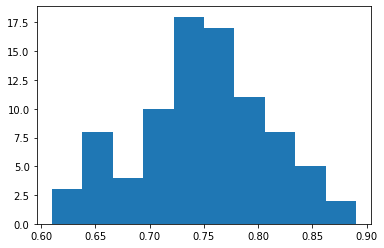

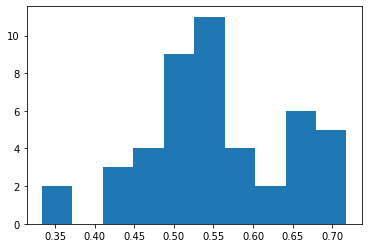

In [80]:
plt.hist(metrics["npmi_all"]["lda"][5])
plt.show()

plt.hist(metrics["npmi_all"]["kmeans"][5])
plt.show()